# Load data

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

import os

import matplotlib as mpl

# mpl.rcParams['figure.dpi'] = 300 # plot in better quality

mean_marker_props = {
    "marker": ".",
    "markerfacecolor": "white",
    "markeredgecolor": "black",
    "markersize": "8",
}

lang_es = {
    "Hemisphere": "Hemisferio",
    "Volume [ml]": "Volumen [ml]",
    "left": "Izquierda",
    "right": "Derecha",
    "tp": "VP",  # Verdadero Positivo
    "fp": "FP",  # Falso Positivo
    "fn": "FN",  # Falso Negativo
    "tn": "VN",  # Verdadero Negativo
    "dc": "Coeficiente Dice",
    "pred_volume": "Volumen predicho [ml]",
    "gt_volume": "Volumen de la segmentación experta [ml]",
}


def model_stats(data: pd.DataFrame):
    low_dc = (
        data.groupby("model", as_index=False)["dc"]
        .apply(lambda x: (x < 0.1).sum())
        .rename(columns={"dc": "dc < 0.1"})
    )
    means = (
        data.groupby("model", as_index=False)[
            ["dc", "precision", "recall", "specificity"]
        ]
        .mean()
        .sort_values("dc", ascending=False)
        .merge(low_dc, on="model")
    )
    std = data.groupby("model", as_index=False)[
        ["dc", "precision", "recall", "specificity"]
    ].std()
    ret = means.merge(std, on="model", suffixes=("", "_std"))
    return ret

## Load GT volumes, predictions and atlas

In [ ]:
gt_volumes = pd.concat(
    [
        pd.read_csv("./csv/ISLES2022_metadata.csv")[
            ["name", "lesion_volume_ml"]
        ].assign(dataset="ISLES2022")
    ],
    ignore_index=True,
)
gt_volumes["name"] = gt_volumes["name"].astype(str)

# load files in csv folder
data = pd.DataFrame()
methods = ["nnUNet"]
for method in methods:
    models = [
        model_csv.replace(".csv", "") for model_csv in os.listdir(f"./csv/{method}")
    ]
    for model in models:
        csv = pd.read_csv(f"./csv/{method}/{model}.csv")
        csv["model"] = model
        csv["method"] = method
        csv = csv.rename(columns={"Unnamed: 0": "name"})
        data = pd.concat([data, csv])

# compute Precision, Recall and Specificity
data["precision"] = data["tp"] / (data["tp"] + data["fp"])
data["recall"] = data["tp"] / (data["tp"] + data["fn"])
data["specificity"] = data["tn"] / (data["tn"] + data["fp"])

isles = data[data["model"] == "ISLES_valid_ens"]

# load atlas analysis
atlas = pd.read_csv("./csv/stat_lobes.csv").rename(columns={"Subject": "name"})

# rescale lesion volumes from MNI space
volumes_in_mni = atlas.groupby(["Dataset", "name"])["Volume [ml]"].sum().reset_index()
volumes_merged = volumes_in_mni.merge(gt_volumes, on="name").set_index("name")
volumes_factor = volumes_merged["Volume [ml]"] / volumes_merged["lesion_volume_ml"]
atlas["Volume [ml]"] = atlas.apply(
    lambda x: x["Volume [ml]"] / volumes_factor[x["name"]], axis=1
)

In [16]:
# merge data with atlas
atlas_dict = {
    0: "No especificado",
    1: "Núcleo caudado",
    2: "Cerebelo",
    3: "Lóbulo frontal",
    4: "Ínsula",
    5: "Lóbulo occipital",
    6: "Lóbulo parietal",
    7: "Putamen",
    8: "Lóbulo temporal",
    9: "Tálamo",
}

atlas["Lobe"] = atlas["Lobe"].map(atlas_dict)

# Metadata analysis

In [17]:
# order = ["Motol", "ISLES2015", "ISLES2022"]
order = ["ISLES2022"]
# compute percentage of lesion volume in hemispheres for each dataset
atlas["Volume [%]"] = (
    atlas["Volume [ml]"]
    / atlas.groupby(["Dataset"])["Volume [ml]"].transform("sum")
    * 100
)

# print percentages
groups = atlas.groupby(["Dataset", "Hemisphere"], as_index=False)
pd.merge(
    groups["Volume [%]"].sum(),
    groups["Volume [ml]"].sum(),
    on=["Dataset", "Hemisphere"],
)

Dataset Hemisphere  Volume [%]  Volume [ml]
0  ISLES2022       left   45.984768  2692.812840
1  ISLES2022      right   54.015232  3163.067197

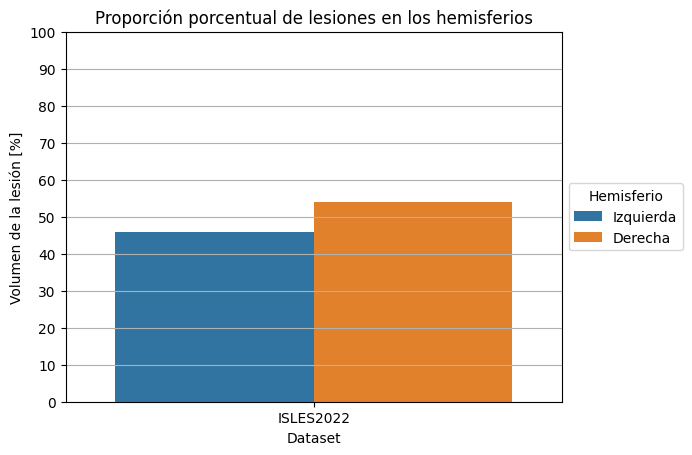

In [18]:
ax = sns.barplot(
    x="Dataset",
    y="Volume [%]",
    data=atlas,
    hue="Hemisphere",
    estimator=sum,
    errorbar=None,
    order=order,
)
ax.set_title("Proporción porcentual de lesiones en los hemisferios")
ax.set_xlabel("Dataset")
ax.set_ylabel("Volumen de la lesión [%]")
ax.legend(
    title="Hemisferio",
    labels=["Izquierda", "Derecha"],
    loc="center left",
    bbox_to_anchor=[1, 0.5],
)
ax.set_yticks(np.arange(0, 101, 10))
ax.grid(axis="y")

In [19]:
# print percentages
groups = atlas.groupby(["Dataset", "Lobe"], as_index=False)
pd.merge(
    groups["Volume [%]"].sum(), groups["Volume [ml]"].sum(), on=["Dataset", "Lobe"]
)

Dataset              Lobe  Volume [%]  Volume [ml]
0  ISLES2022          Cerebelo   17.020005   996.671081
1  ISLES2022    Lóbulo frontal   19.907300  1165.747624
2  ISLES2022  Lóbulo occipital   10.066439   589.478614
3  ISLES2022   Lóbulo parietal   17.030703   997.297563
4  ISLES2022   Lóbulo temporal   12.970874   759.558823
5  ISLES2022   No especificado    8.334257   488.044074
6  ISLES2022    Núcleo caudado    3.359482   196.727212
7  ISLES2022           Putamen    4.583455   268.401622
8  ISLES2022            Tálamo    1.237537    72.468686
9  ISLES2022            Ínsula    5.489947   321.484737

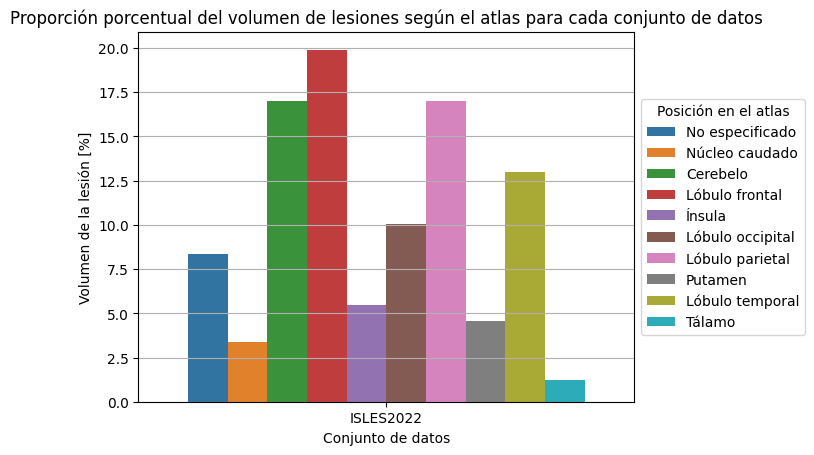

In [20]:
ax = sns.barplot(
    x="Dataset",
    y="Volume [%]",
    data=atlas,
    hue="Lobe",
    estimator=sum,
    errorbar=None,
    palette="tab10",
    order=order,
)
ax.set_title(
    "Proporción porcentual del volumen de lesiones según el atlas para cada conjunto de datos"
)
ax.set_xlabel("Conjunto de datos")
ax.set_ylabel("Volumen de la lesión [%]")
ax.legend(title="Posición en el atlas", loc="center left", bbox_to_anchor=[1, 0.5])
ax.grid(axis="y")

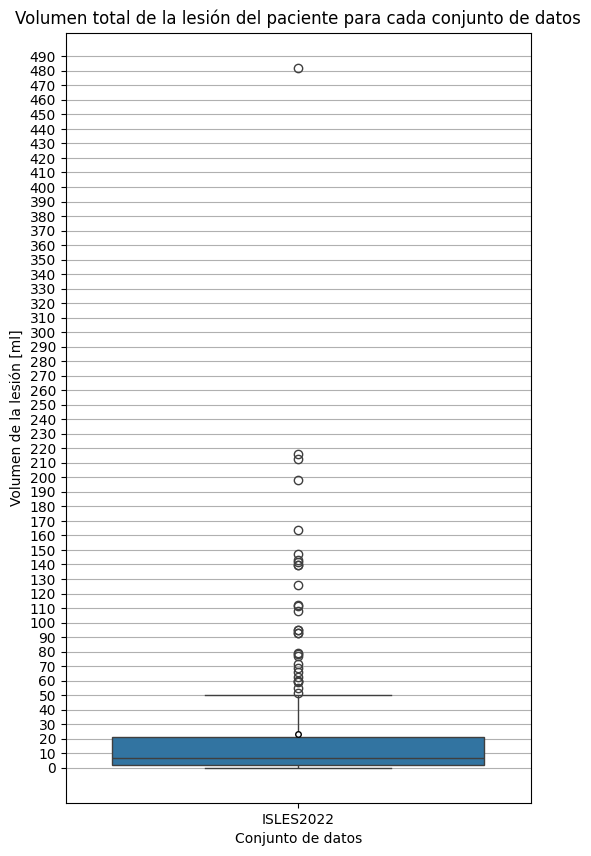

In [21]:
plt.figure(figsize=(6, 10))
ax = sns.boxplot(
    x="dataset",
    y="lesion_volume_ml",
    data=gt_volumes,
    hue="dataset",
    showmeans=True,
    meanprops=mean_marker_props,
    order=order,
)
ax.set_title("Volumen total de la lesión del paciente para cada conjunto de datos")
ax.set_xlabel("Conjunto de datos")
ax.set_ylabel("Volumen de la lesión [ml]")
ax.set_yticks(np.arange(0, 500, 10))
ax.grid(axis="y")

# Results of each method

## nnU-Net

In [22]:
nnunet = data[data["method"] == "nnUNet"].copy()
nnunet["model"] = nnunet["model"].str.replace(r"Dataset\d\d\d_", "", regex=True)
model_stats(nnunet)

model        dc  precision    recall  specificity  dc < 0.1  \
0       StrokesMNI  0.559374   0.649592  0.608978     0.991019         5   
1  ISLES_valid_ens  0.380802   0.375882  0.502006     0.989076        84   

     dc_std  precision_std  recall_std  specificity_std  
0  0.264614       0.302246    0.275869         0.010611  
1  0.329881       0.352447    0.349171         0.013635

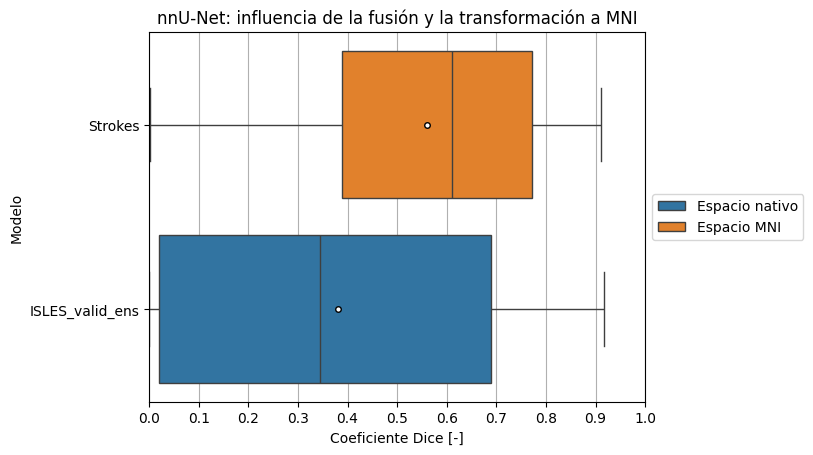

In [23]:
plot_data = nnunet.loc[~data["model"].str.contains("MotolOnly")].copy()
plot_data["MNI"] = nnunet["model"].str.contains("MNI")
plot_data["model"] = nnunet["model"].str.replace(r"_MNI|MNI", "", regex=True)
ax = sns.boxplot(
    data=plot_data,
    x="dc",
    y="model",
    hue="MNI",
    orient="h",
    showmeans=True,
    meanprops=mean_marker_props,
)

legend_handles, _ = ax.get_legend_handles_labels()
ax.legend(
    legend_handles,
    ["Espacio nativo", "Espacio MNI"],
    loc="center left",
    bbox_to_anchor=[1, 0.5],
)

ax.set_title("nnU-Net: influencia de la fusión y la transformación a MNI")
ax.set_xlabel("Coeficiente Dice [-]")
ax.set_ylabel("Modelo")
ax.set_xlim(-0, 1)
ax.set_xticks(np.arange(0, 1.01, 0.1))
ax.grid(axis="x")

### ISLES validation

In [24]:
model_stats(isles)

model        dc  precision    recall  specificity  dc < 0.1  \
0  ISLES_valid_ens  0.380802   0.375882  0.502006     0.989076        84   

     dc_std  precision_std  recall_std  specificity_std  
0  0.329881       0.352447    0.349171         0.013635

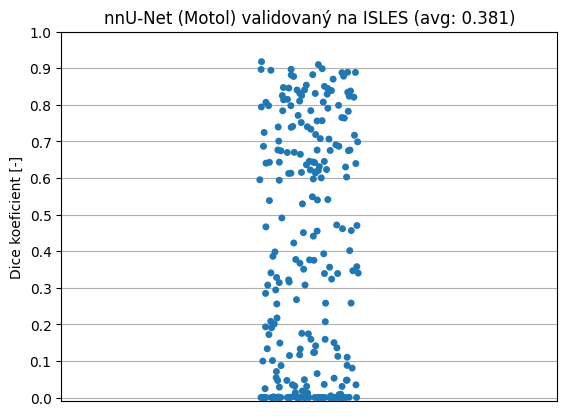

In [29]:
ax = sns.stripplot(data=isles[["name", "dc"]])
ax.set_title(f"nnU-Net (Motol) validovaný na ISLES (avg: {isles['dc'].mean():0.3f})")
ax.set_ylabel("Dice koeficient [-]")
ax.set_xticks([])
ax.set_ylim(-0.01, 1)
ax.set_yticks(np.arange(0, 1.01, 0.1))
ax.grid(axis="y")

C:\Users\Carlo\AppData\Local\Temp\ipykernel_8812\1499333695.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isles["dataset"] = np.where(isles["name"].str.contains("sub"), "2022", "2015")


dataset
2022    84
Name: dc, dtype: int64

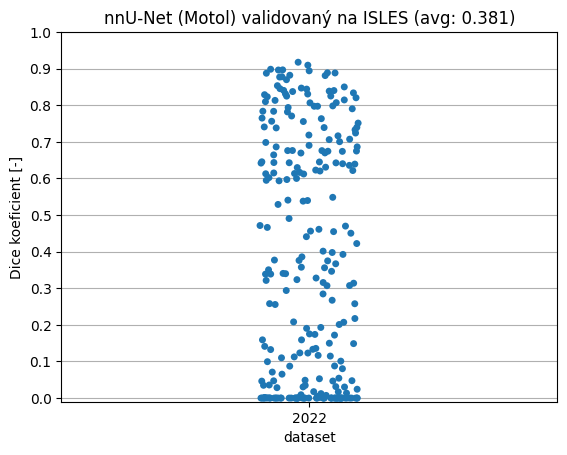

In [ ]:
isles["dataset"] = np.where(isles["name"].str.contains("sub"), "2022", "2015")

ax = sns.stripplot(data=isles, y="dc", x="dataset", orient="v", hue="dataset")
ax.set_title(f"nnU-Net (Motol) validovaný na ISLES (avg: {isles['dc'].mean():0.3f})")
ax.set_ylabel("Dice koeficient [-]")
ax.set_ylim(-0.01, 1)
ax.set_yticks(np.arange(0, 1.01, 0.1))
ax.grid(axis="y")
isles[isles["dc"] < 0.1].groupby("dataset")["dc"].count()

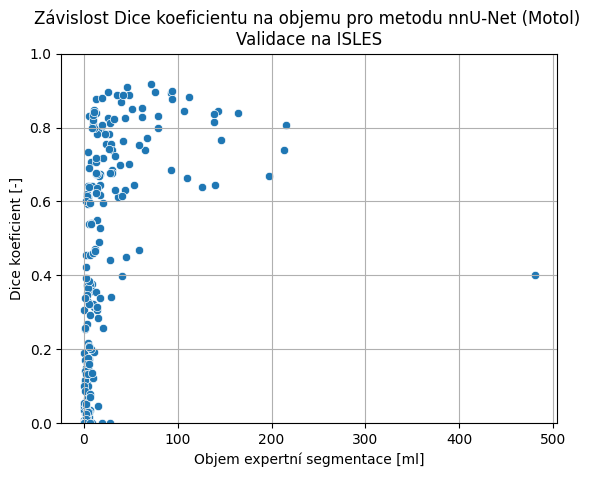

In [32]:
ax = sns.scatterplot(x=isles["gt_volume"], y=isles["dc"])
ax.set_title(
    f"Závislost Dice koeficientu na objemu pro metodu nnU-Net (Motol) \nValidace na ISLES"
)
ax.set_xlabel("Objem expertní segmentace [ml]")
ax.set_ylabel("Dice koeficient [-]")
ax.set_ylim(0, 1)
ax.grid()

# T-tests

Input fusion vs Decision level fusion

In [33]:
models = ["StrokesMNI", "ensemble_FLAIR_DWI_MNI"]
plot_data = nnunet[nnunet["model"].isin(models)]

stats.ttest_rel(
    plot_data["dc"][plot_data["model"] == models[0]],
    plot_data["dc"][plot_data["model"] == models[1]],
    alternative="less",
)

ValueError: Array shapes are incompatible for broadcasting.

# Comparison of the best models

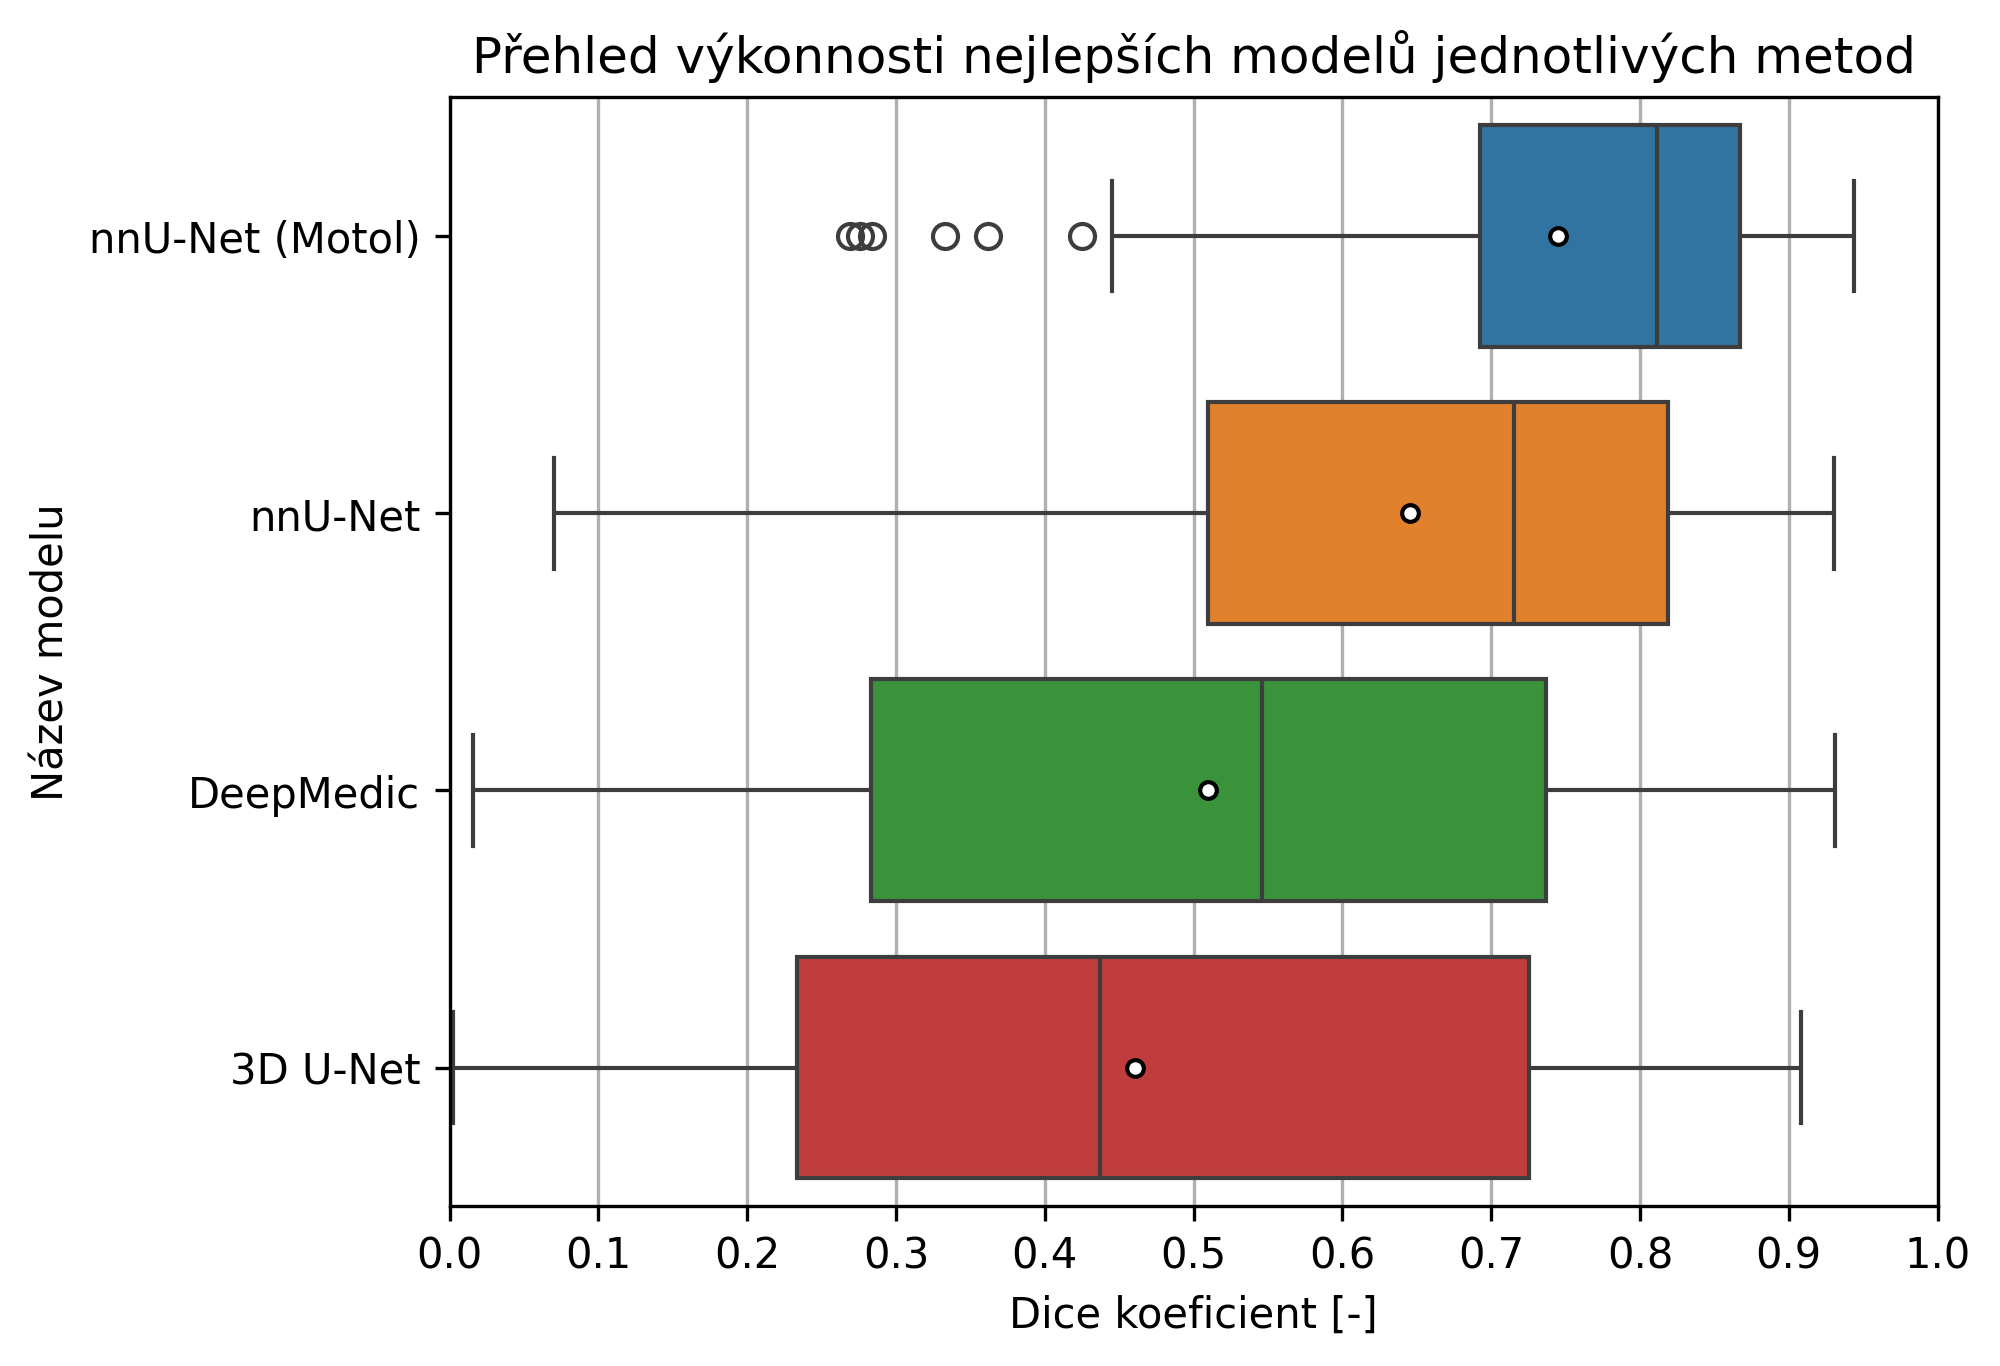

In [ ]:
top_models = [
    "Dataset021_MotolOnly",
    "ensemble_FLAIR_DWI_MNI",
    "ensemble_DWI_FLAIR",
    "ensemble_FLAIR_DWI_LabelSampler",
]
top_models_ticks = ["nnU-Net (Motol)", "nnU-Net", "DeepMedic", "3D U-Net"]
top_data = data[data["model"].isin(top_models)].copy()

ax = sns.boxplot(
    data=top_data,
    x="dc",
    y="model",
    hue="model",
    orient="h",
    palette="tab10",
    showmeans=True,
    meanprops=mean_marker_props,
)
ax.set_yticks([0, 1, 2, 3])
ax.set_yticklabels(top_models_ticks)
ax.set_title("Přehled výkonnosti nejlepších modelů jednotlivých metod")
ax.set_xlabel("Dice koeficient [-]")
ax.set_ylabel("Název modelu")
ax.set_xlim(-0, 1)
ax.set_xticks(np.arange(0, 1.01, 0.1))
ax.grid(axis="x")

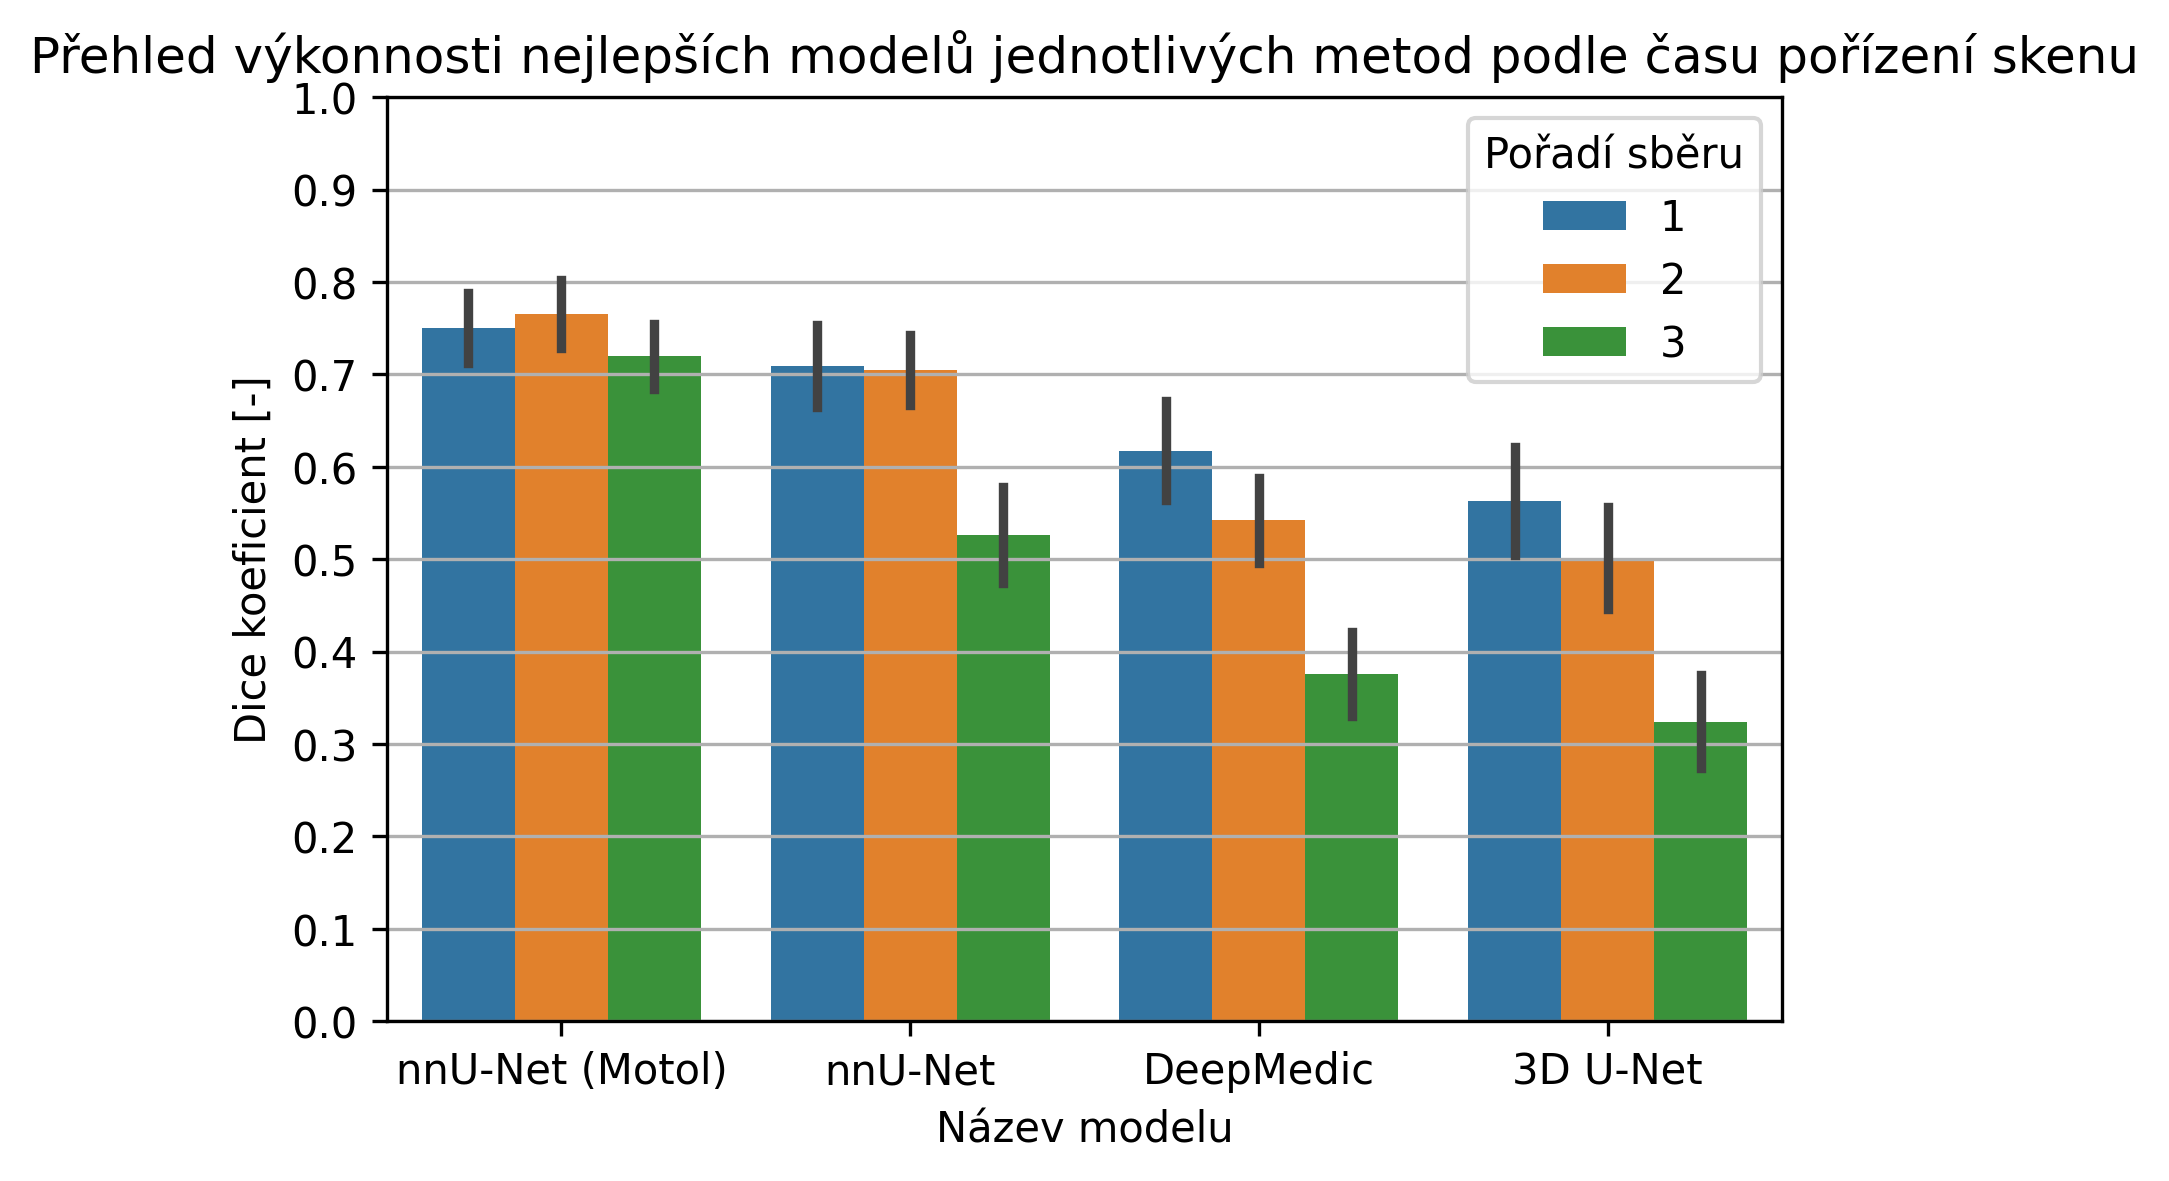

In [ ]:
top_melt = top_data.melt(id_vars=["model", "stage"], value_vars=["dc"])

plt.figure(figsize=(6, 4))
ax = sns.barplot(
    data=top_melt,
    y="value",
    x="model",
    hue="stage",
    order=top_models,
    palette="tab10",
    errorbar=("sd", 0.2),
)
sns.move_legend(ax, "center left", bbox_to_anchor=[1, 0.5])
ax.set_xticks([0, 1, 2, 3])  # surpress warning
ax.set_xticklabels(top_models_ticks)
ax.set_title(
    "Přehled výkonnosti nejlepších modelů jednotlivých metod podle času pořízení skenu"
)
ax.set_ylabel("Dice koeficient [-]")
ax.set_xlabel("Název modelu")
ax.legend(title="Pořadí sběru")
ax.set_ylim(-0, 1)
ax.set_yticks(np.arange(0, 1.01, 0.1))
ax.grid(axis="y")

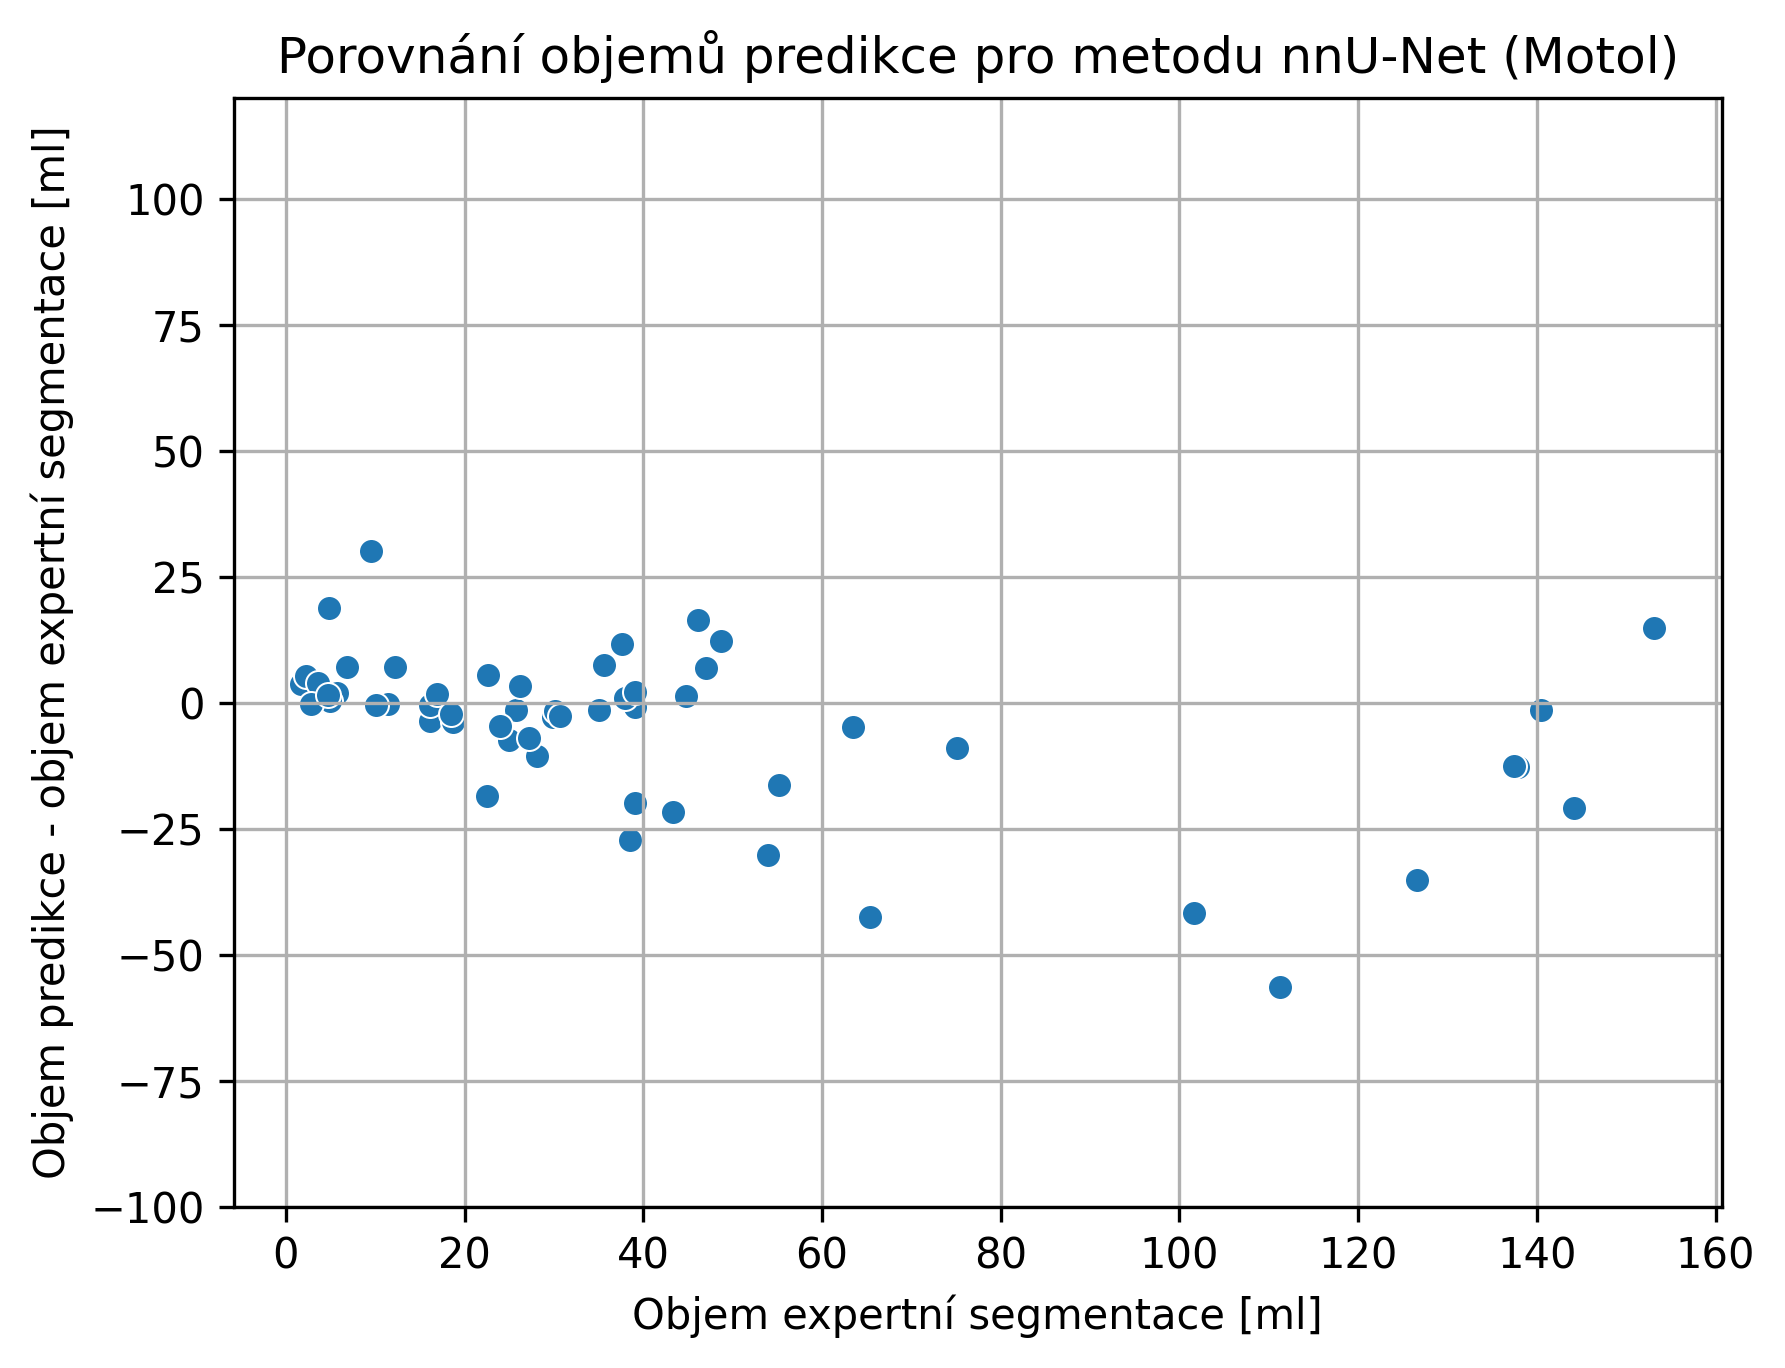

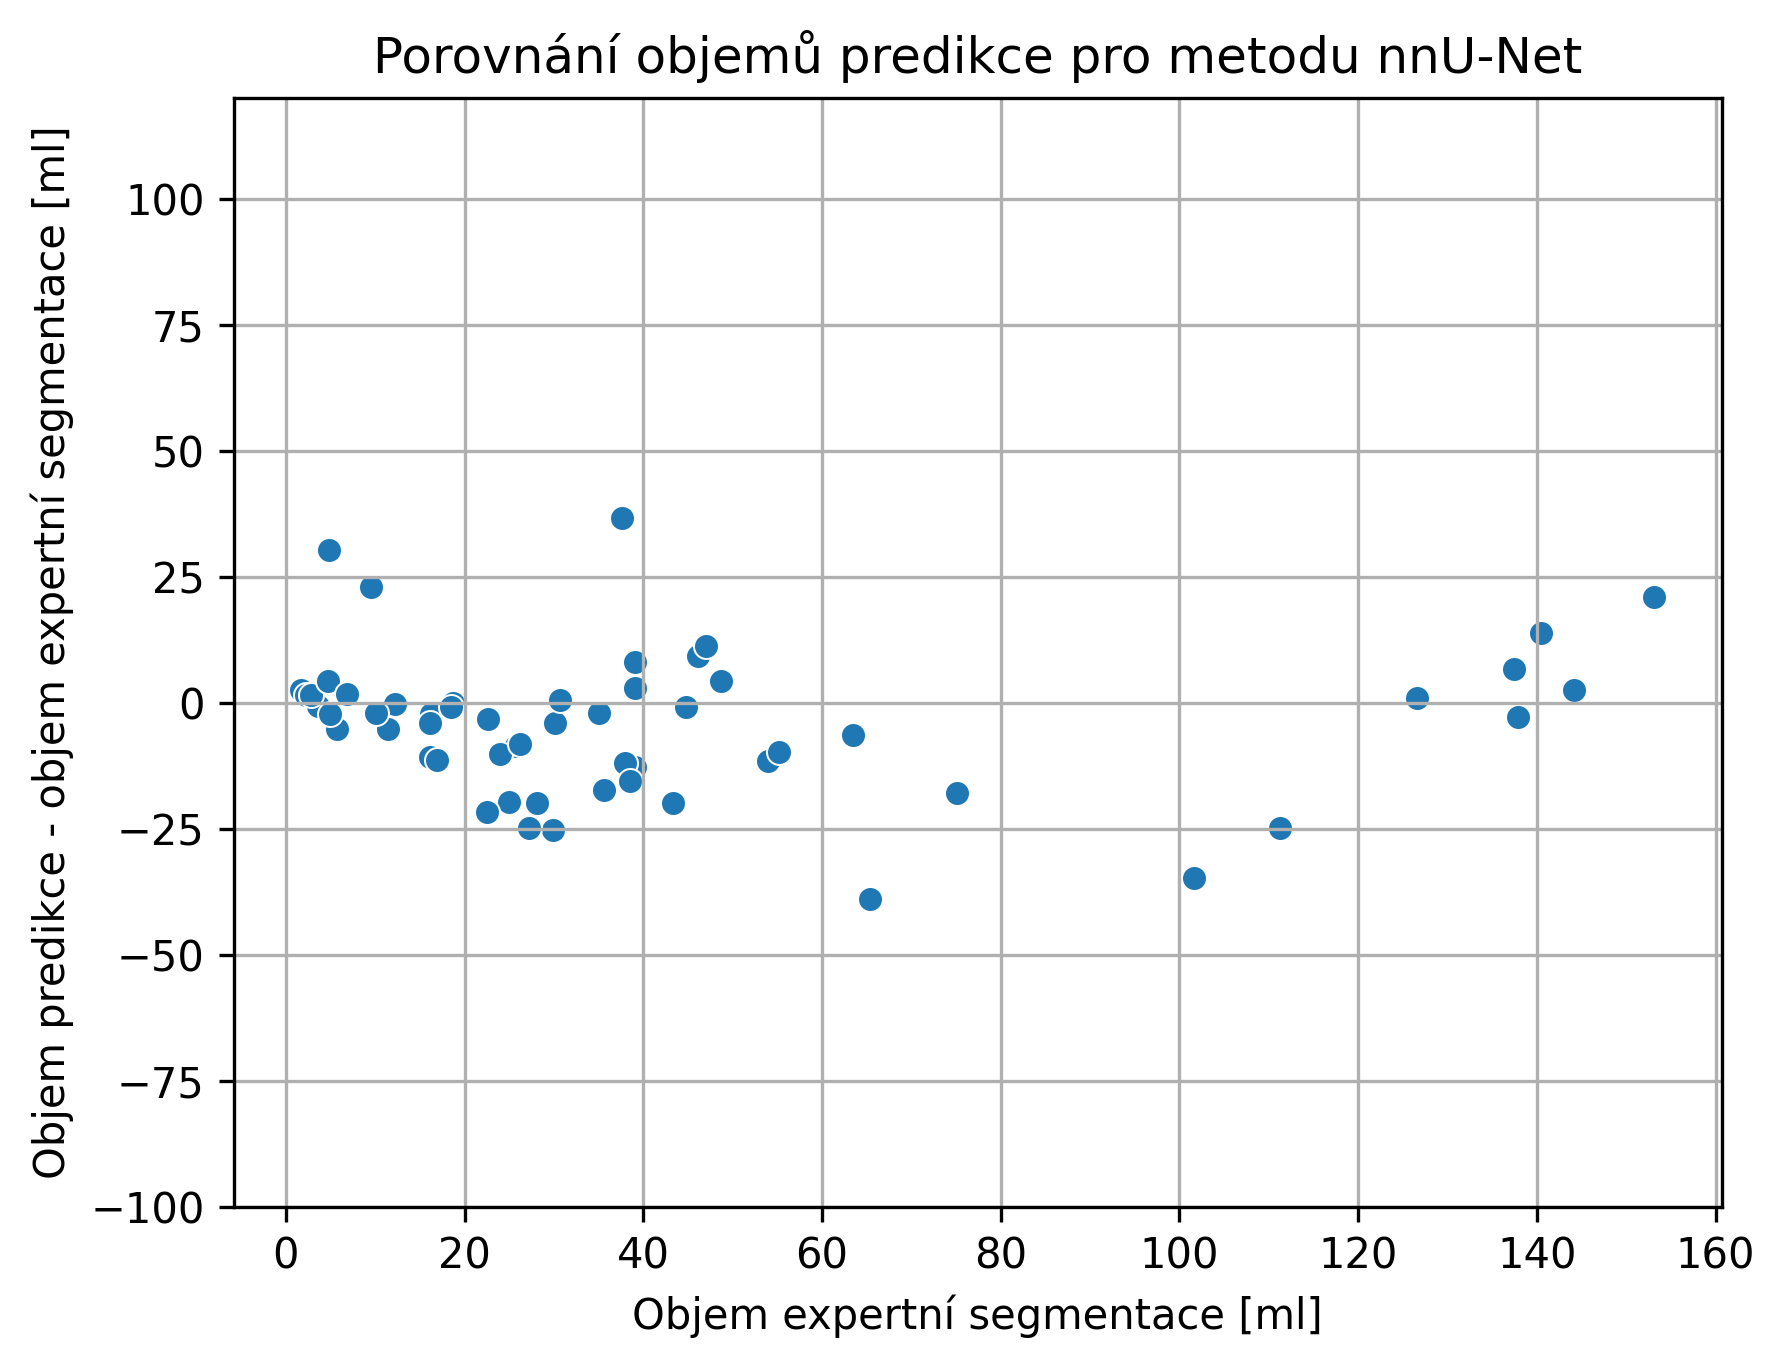

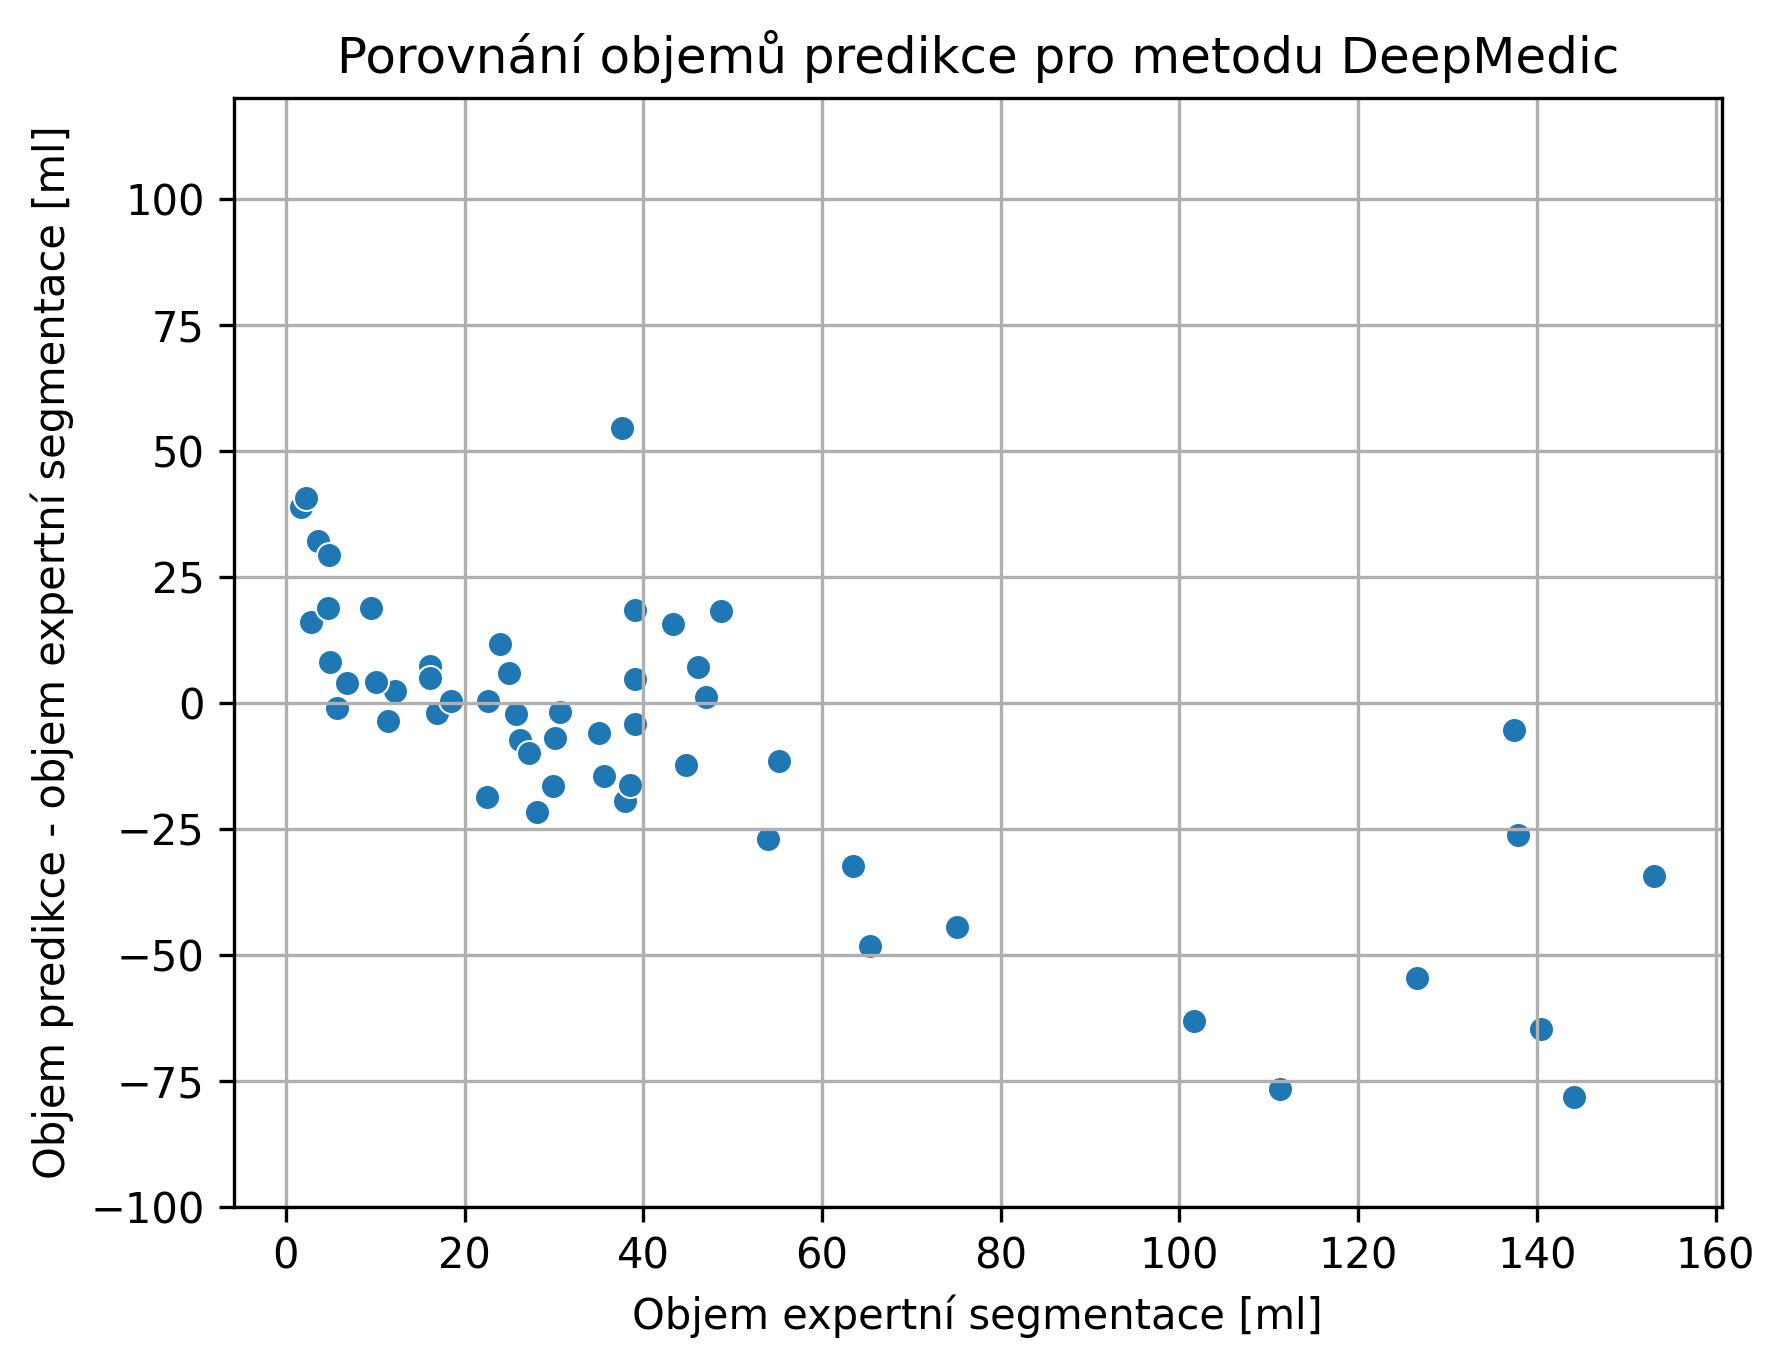

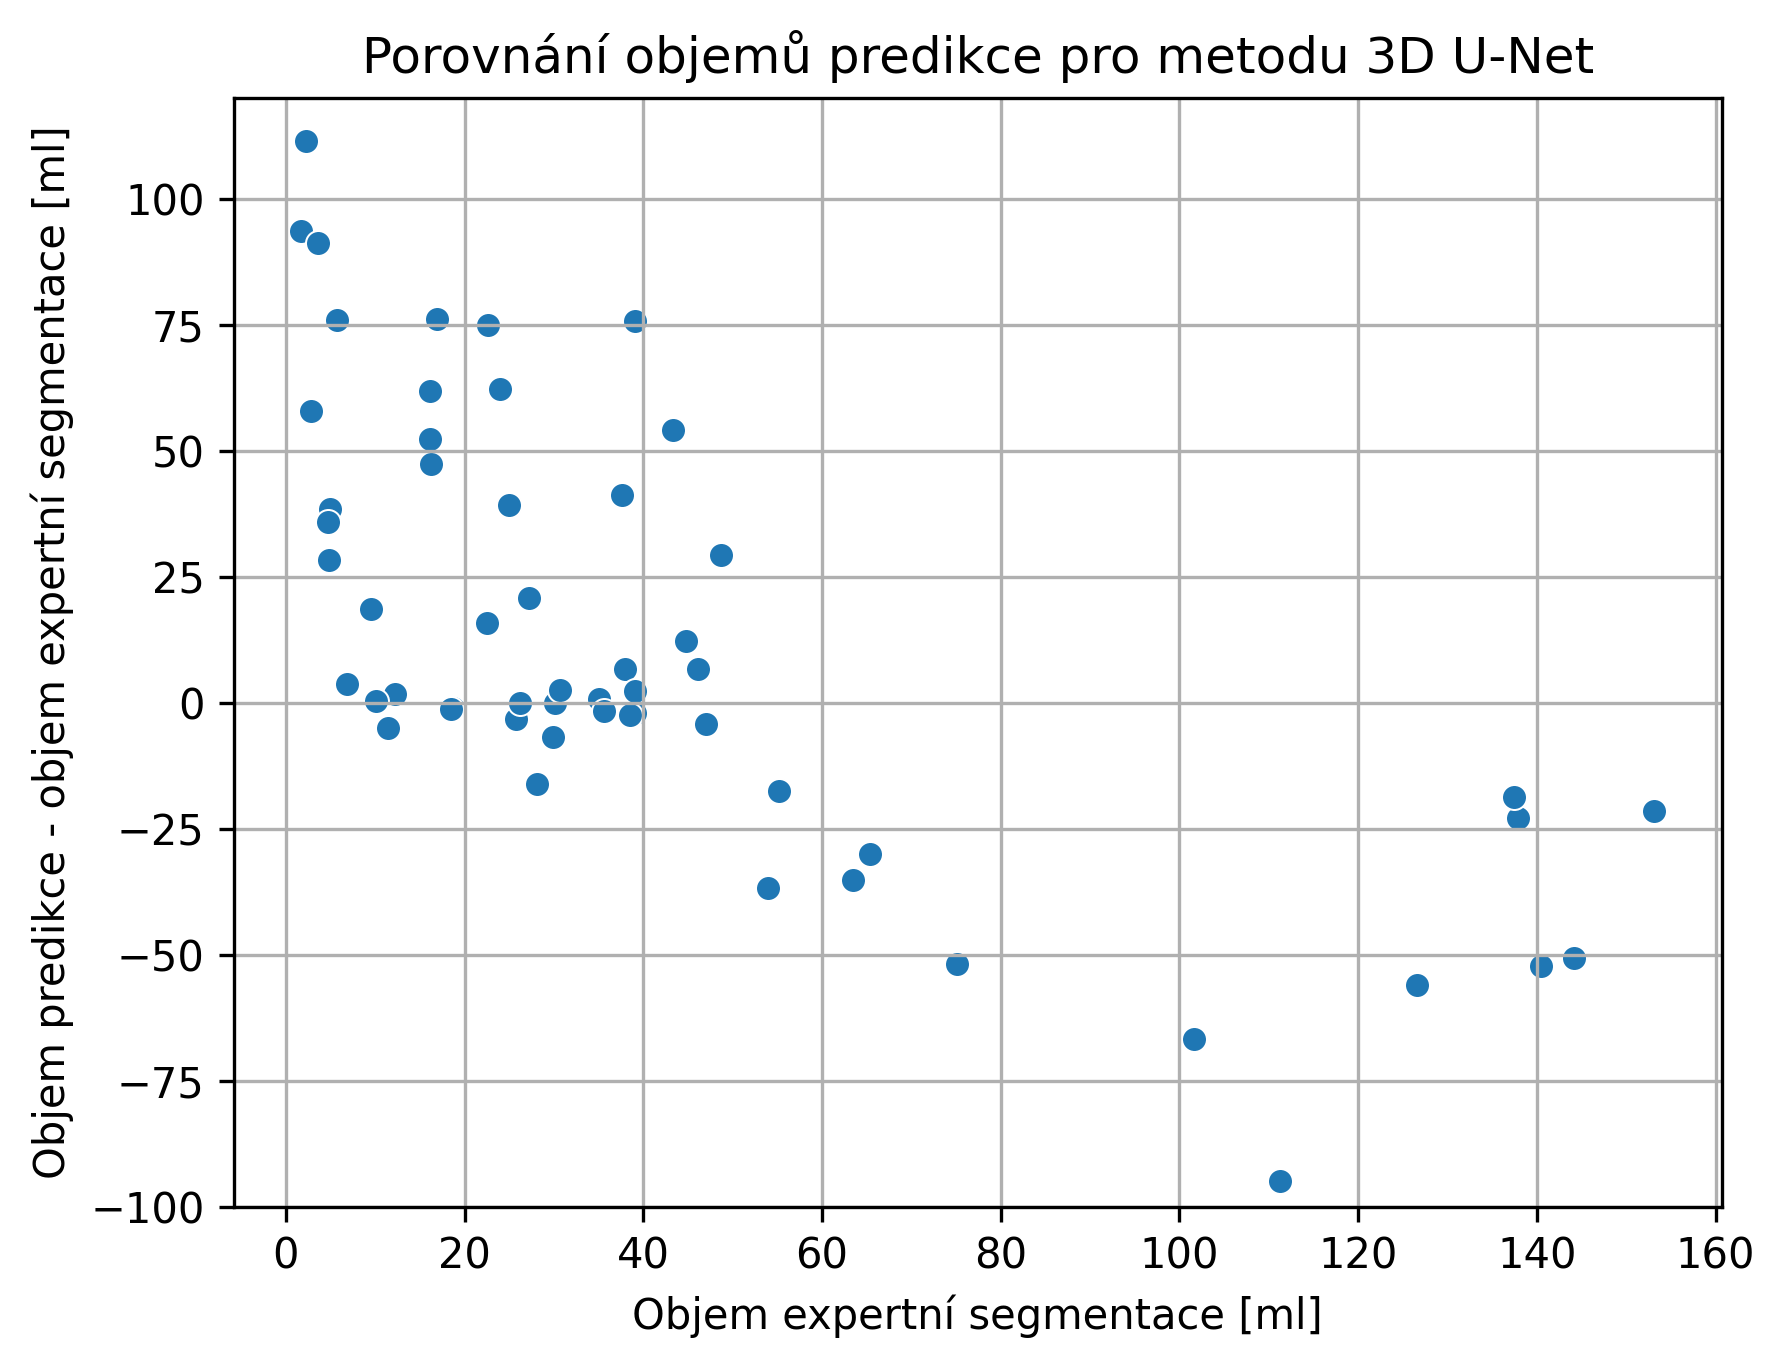

<Figure size 1920x1440 with 0 Axes>

In [54]:
for model, tick in zip(top_models, top_models_ticks):
    top_data["volume_diff"] = top_data["pred_volume"] - top_data["gt_volume"]
    diff = top_data.loc[top_data["model"] == model]["volume_diff"]
    expert = top_data.loc[top_data["model"] == model]["gt_volume"]

    ax = sns.scatterplot(x=expert, y=diff)
    ax.set_title(f"Porovnání objemů predikce pro metodu {tick}")
    ax.set_xlabel("Objem expertní segmentace [ml]")
    ax.set_ylabel("Objem predikce - objem expertní segmentace [ml]")
    ax.set_ylim(-100, 120)
    ax.grid()
    plt.figure()

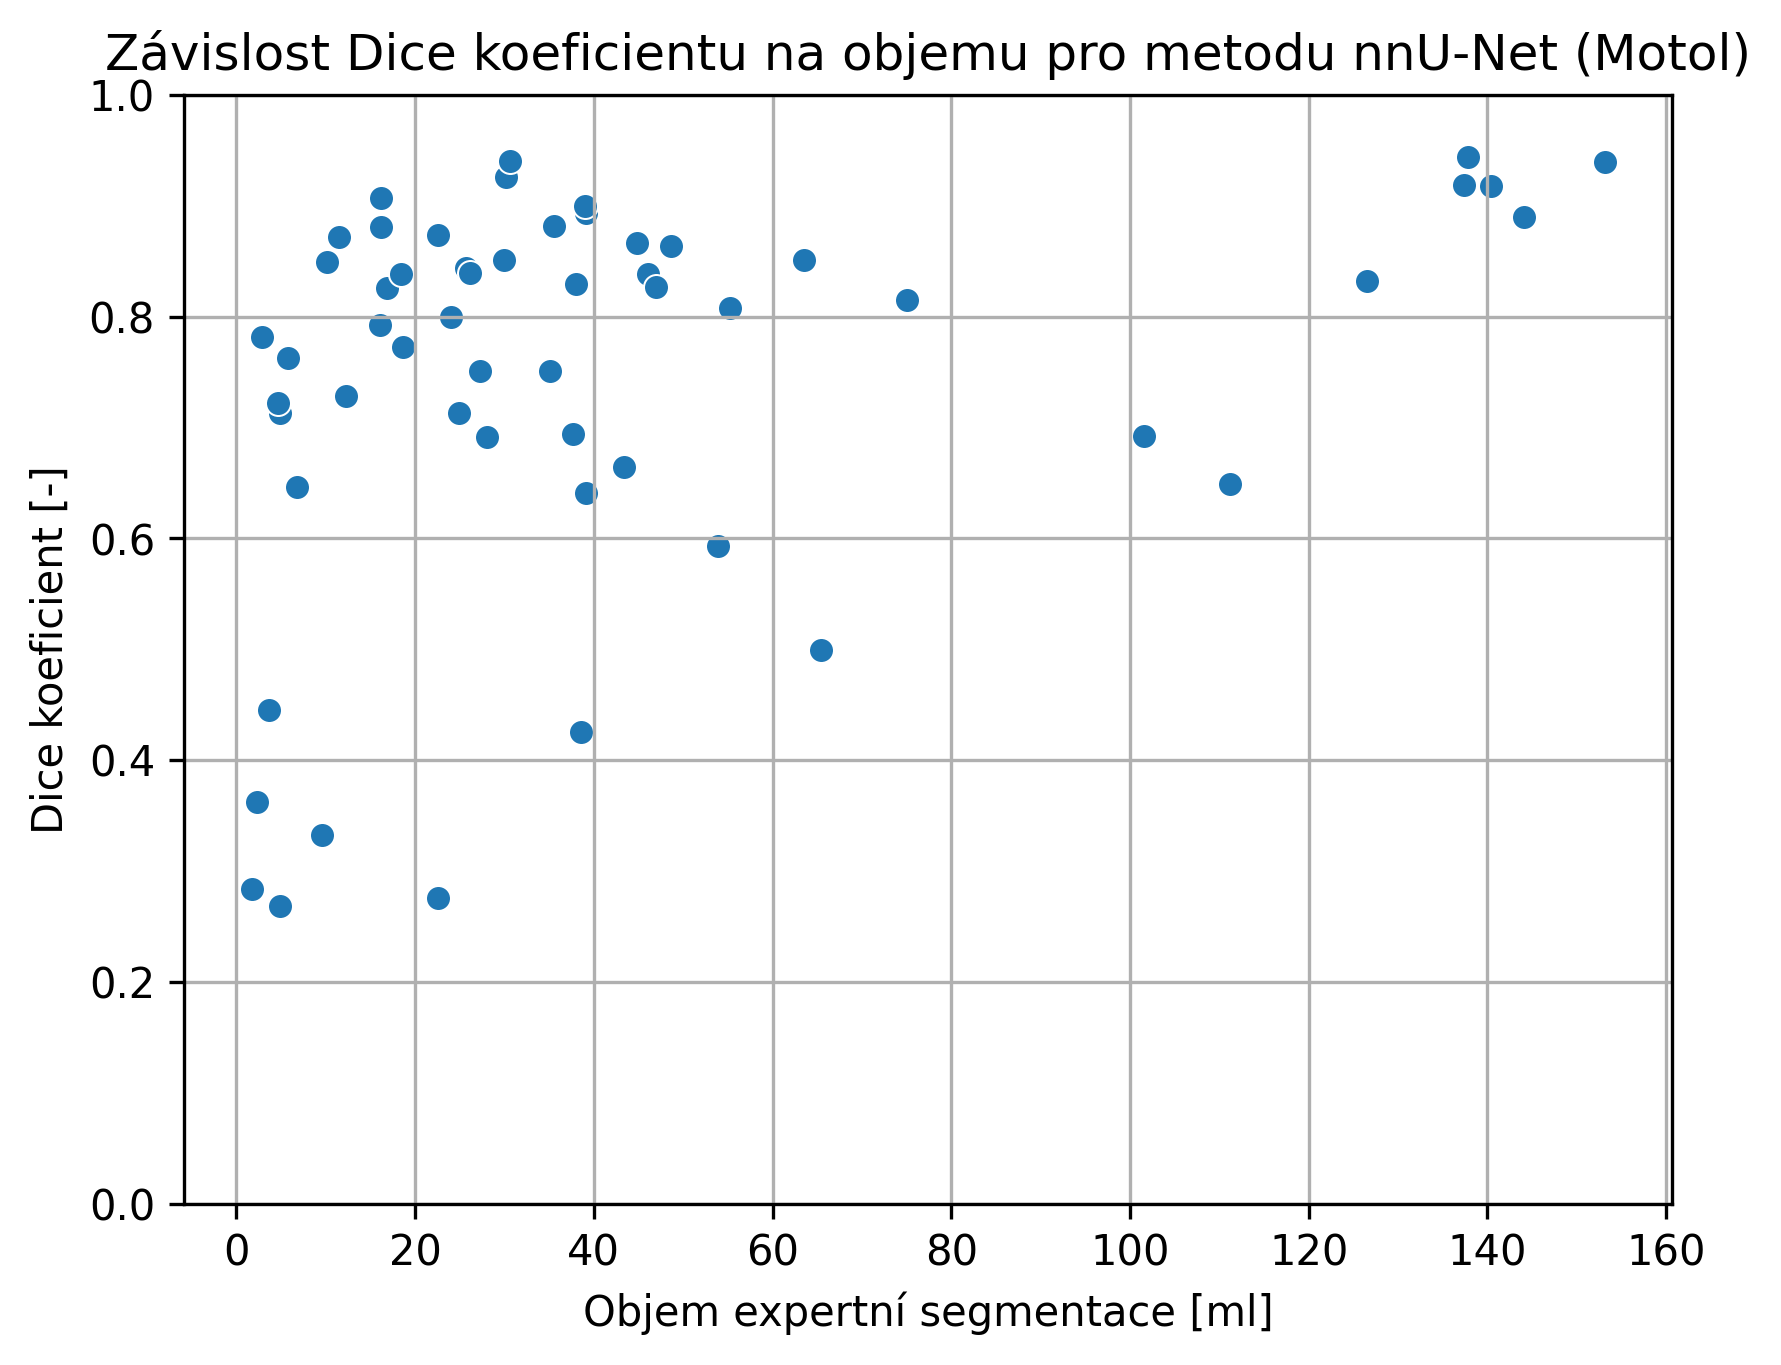

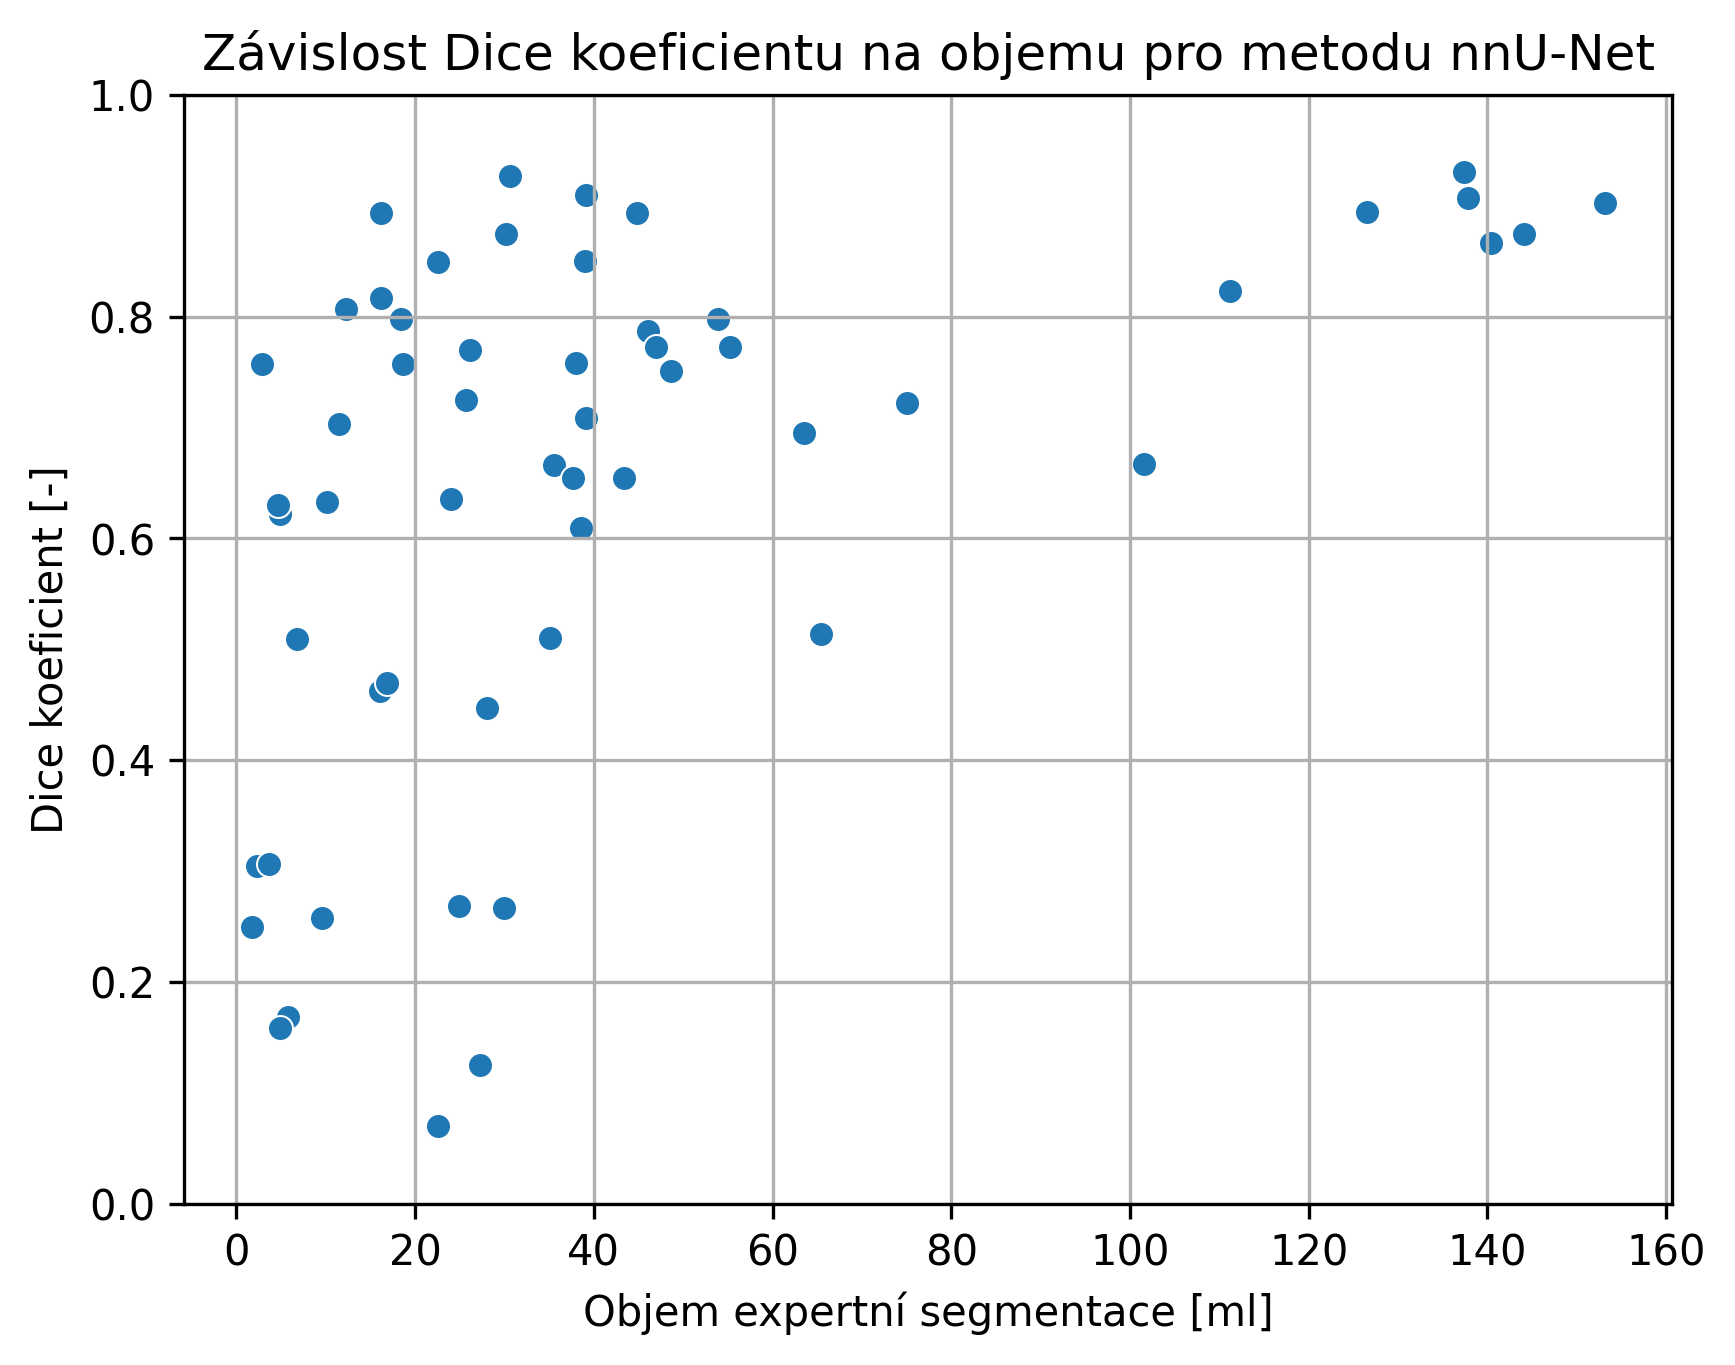

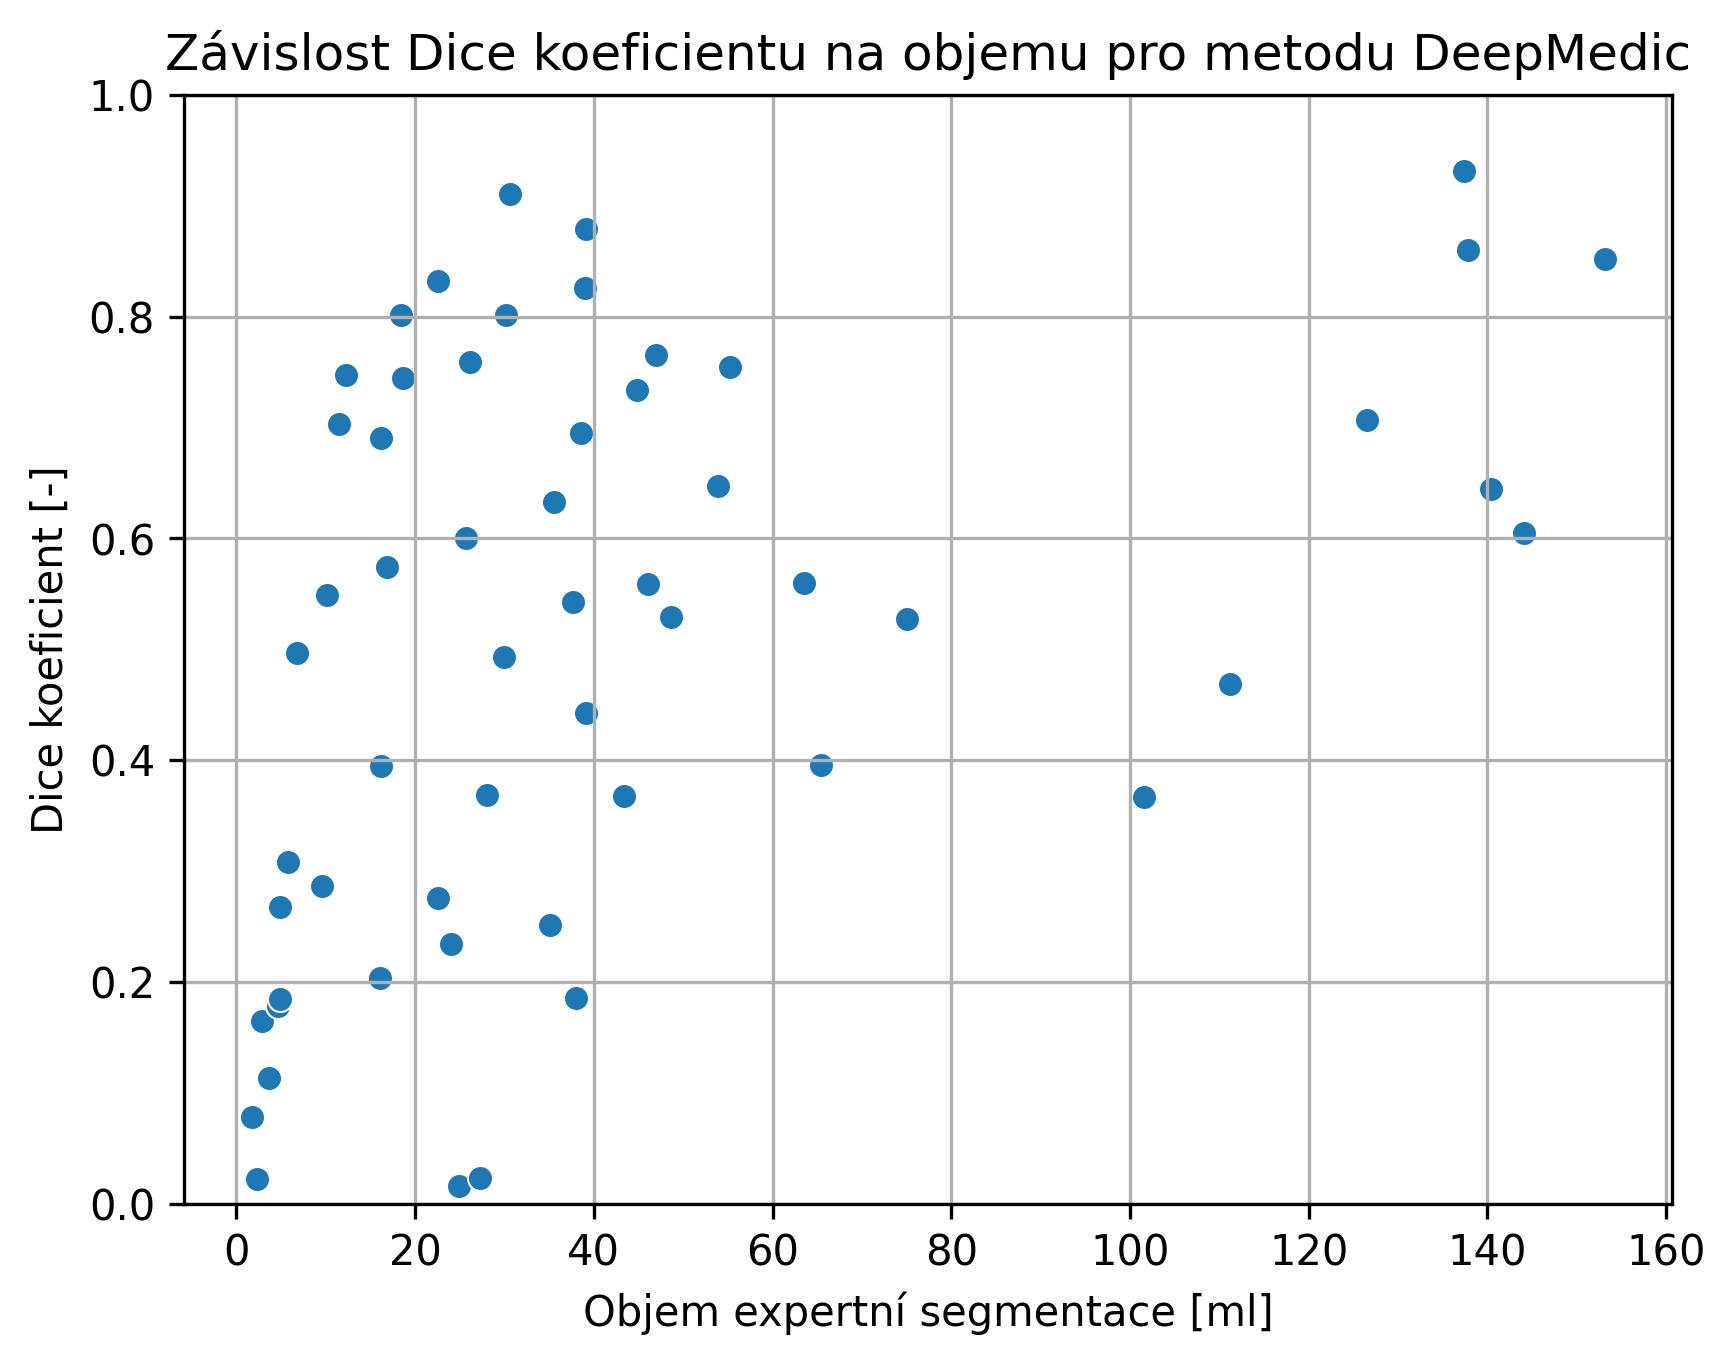

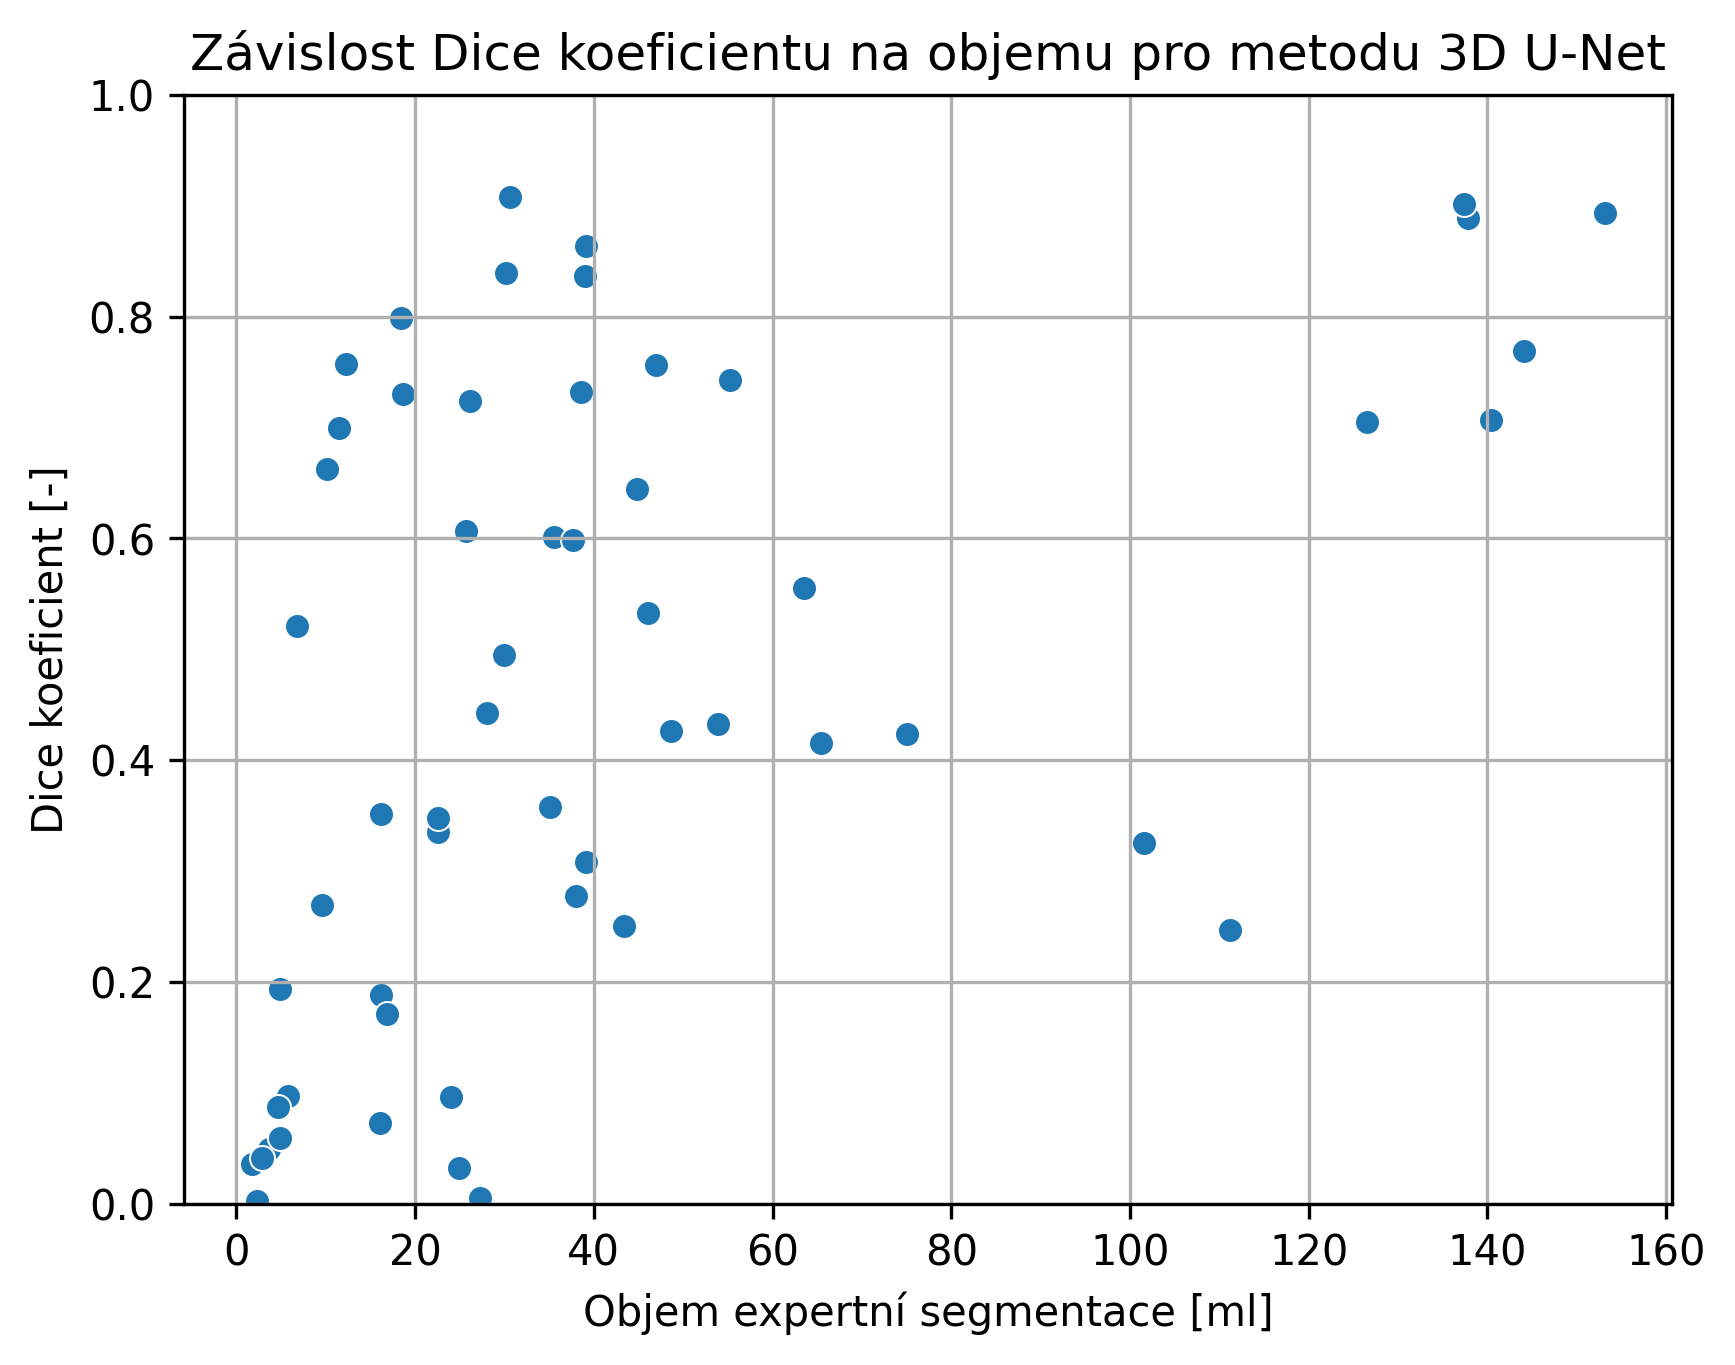

<Figure size 1920x1440 with 0 Axes>

In [ ]:
for model, tick in zip(top_models, top_models_ticks):
    ax = sns.scatterplot(
        x=top_data.loc[top_data["model"] == model]["gt_volume"],
        y=top_data.loc[top_data["model"] == model]["dc"],
    )
    ax.set_title(f"Závislost Dice koeficientu na objemu pro metodu {tick}")
    ax.set_xlabel("Objem expertní segmentace [ml]")
    ax.set_ylabel("Dice koeficient [-]")
    ax.set_ylim(0, 1)
    ax.grid()
    plt.figure()

Text(212.16666666666663, 0.5, 'Název validačního skenu')

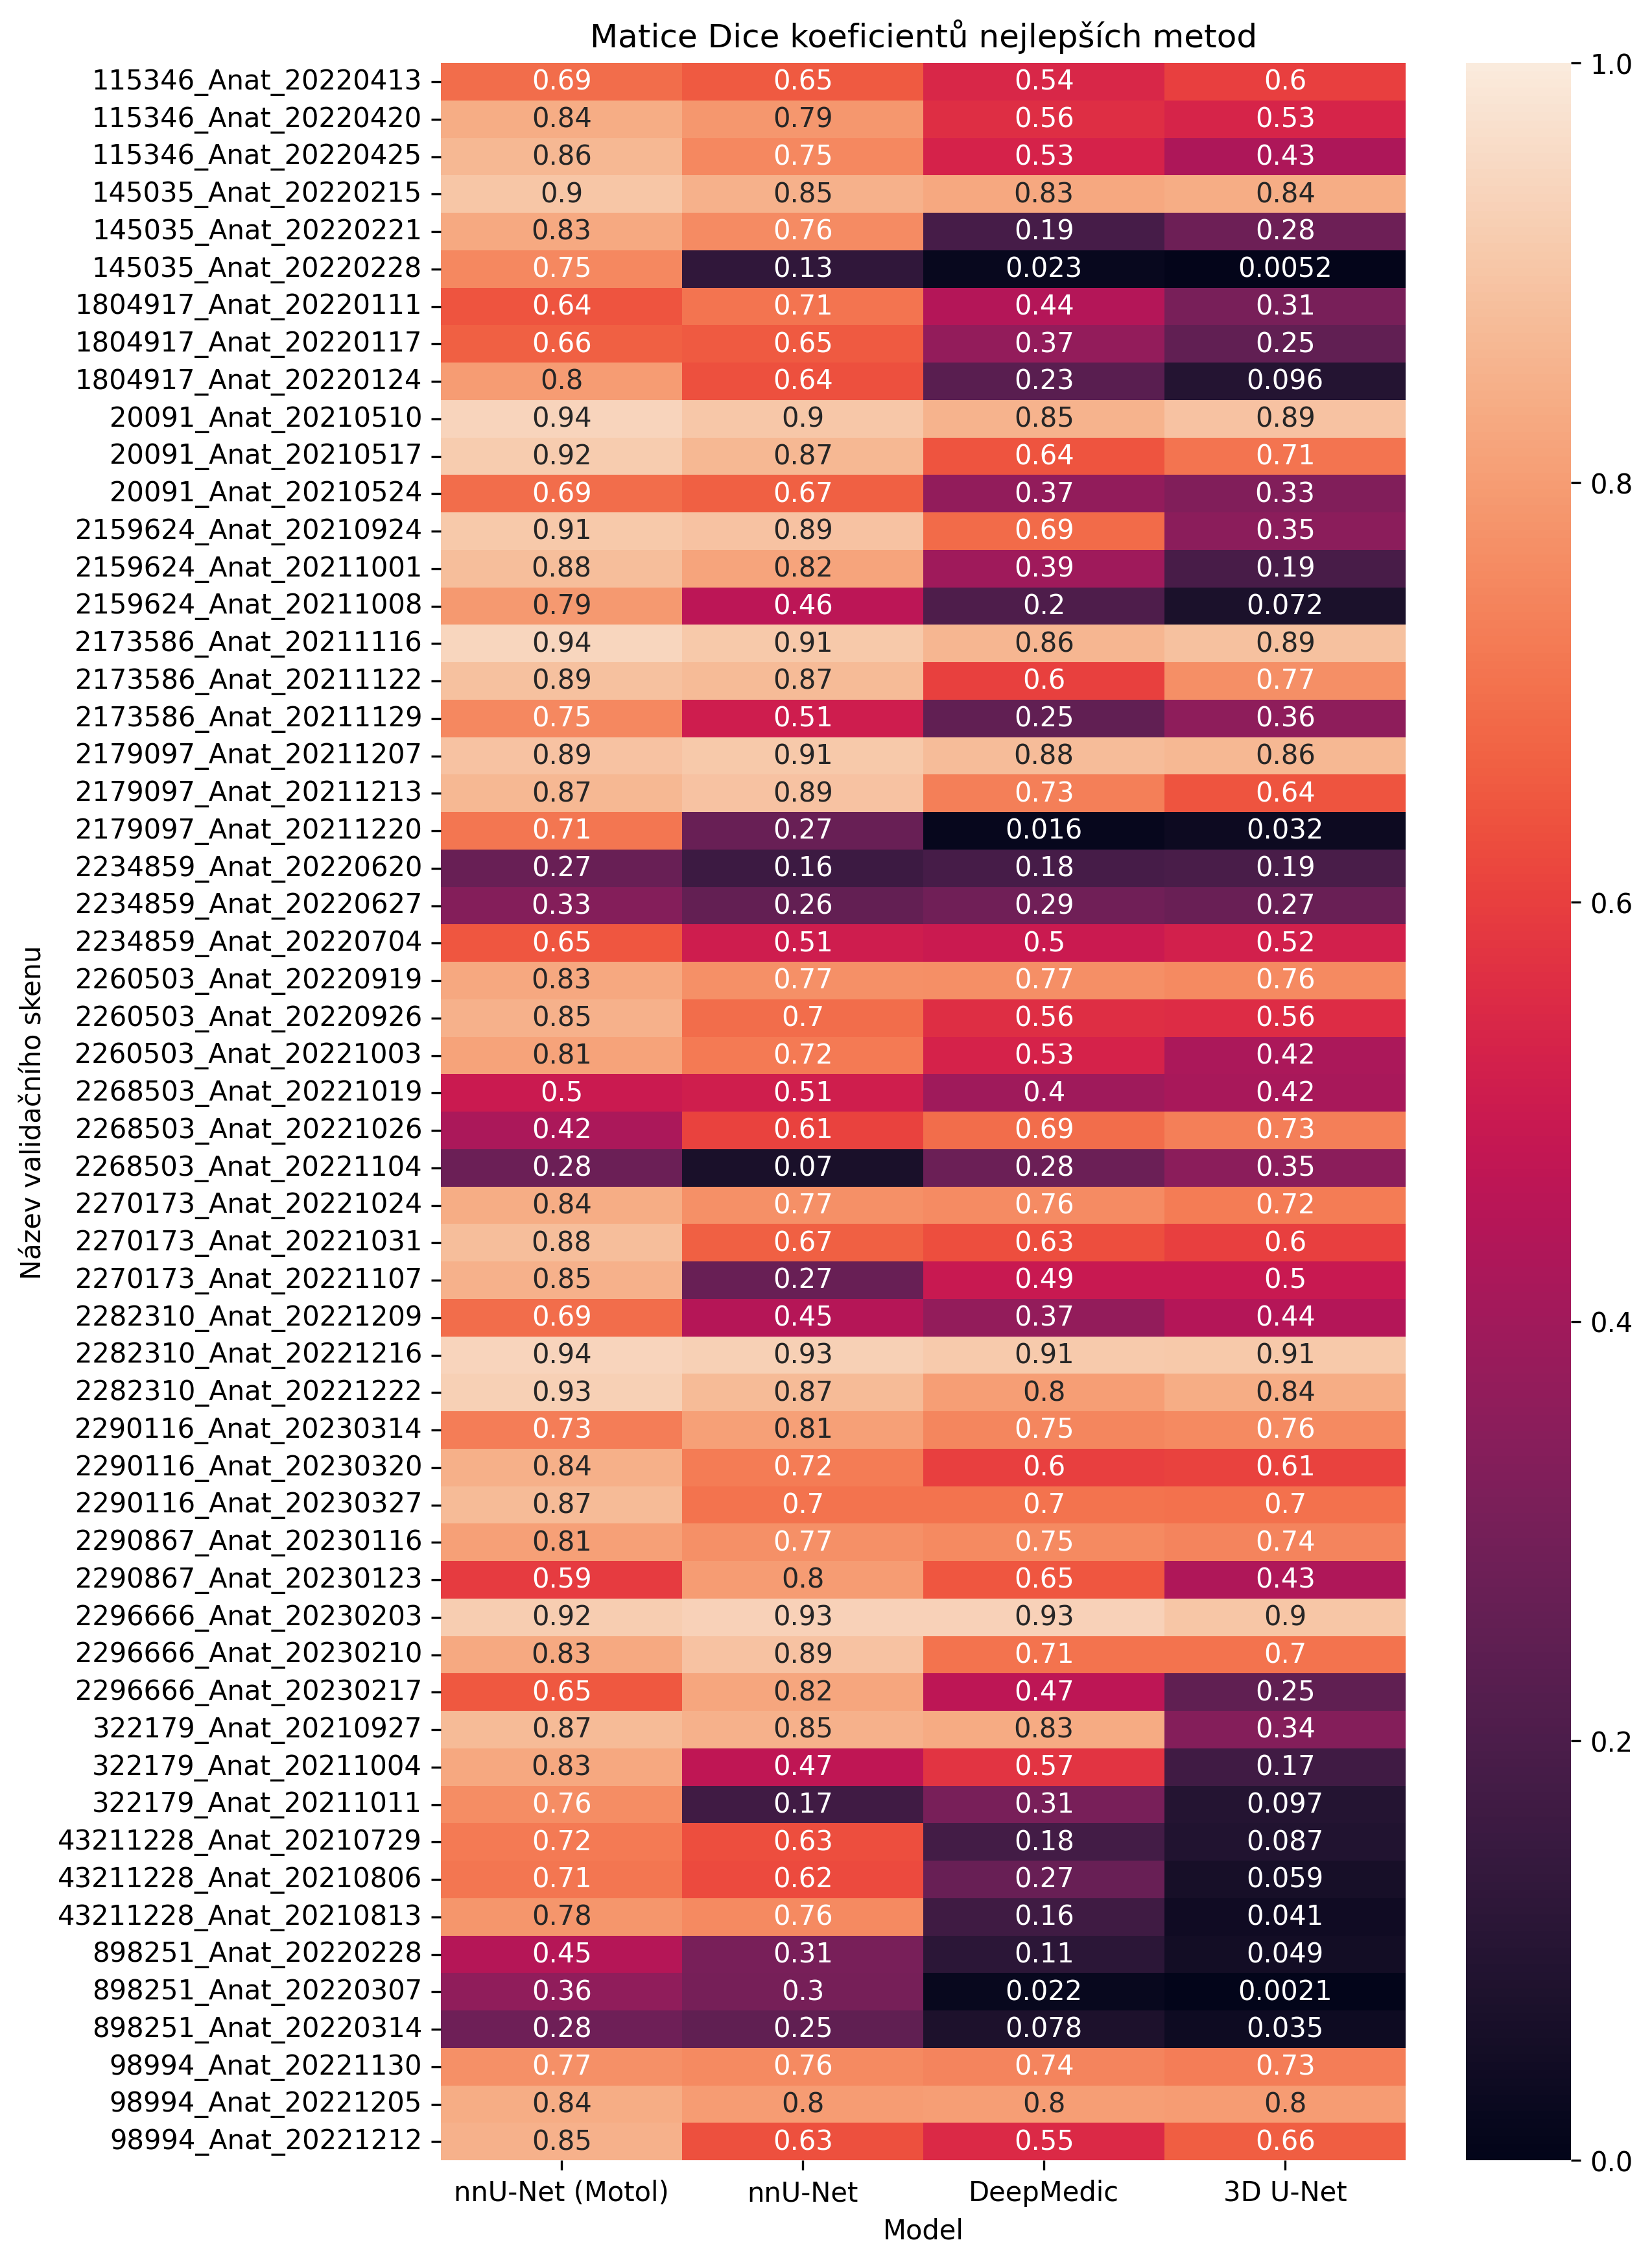

In [ ]:
plt.figure(figsize=(8, 14))
matrix = top_data.pivot(index="name", columns="model", values="dc").reindex(
    columns=top_models
)
ax = sns.heatmap(data=matrix, xticklabels=top_models_ticks, vmin=0, vmax=1, annot=True)

ax.set_title("Matice Dice koeficientů nejlepších metod")
ax.set_xlabel("Model")
ax.set_ylabel("Název validačního skenu")

Text(212.16666666666663, 0.5, 'Název validačního skenu')

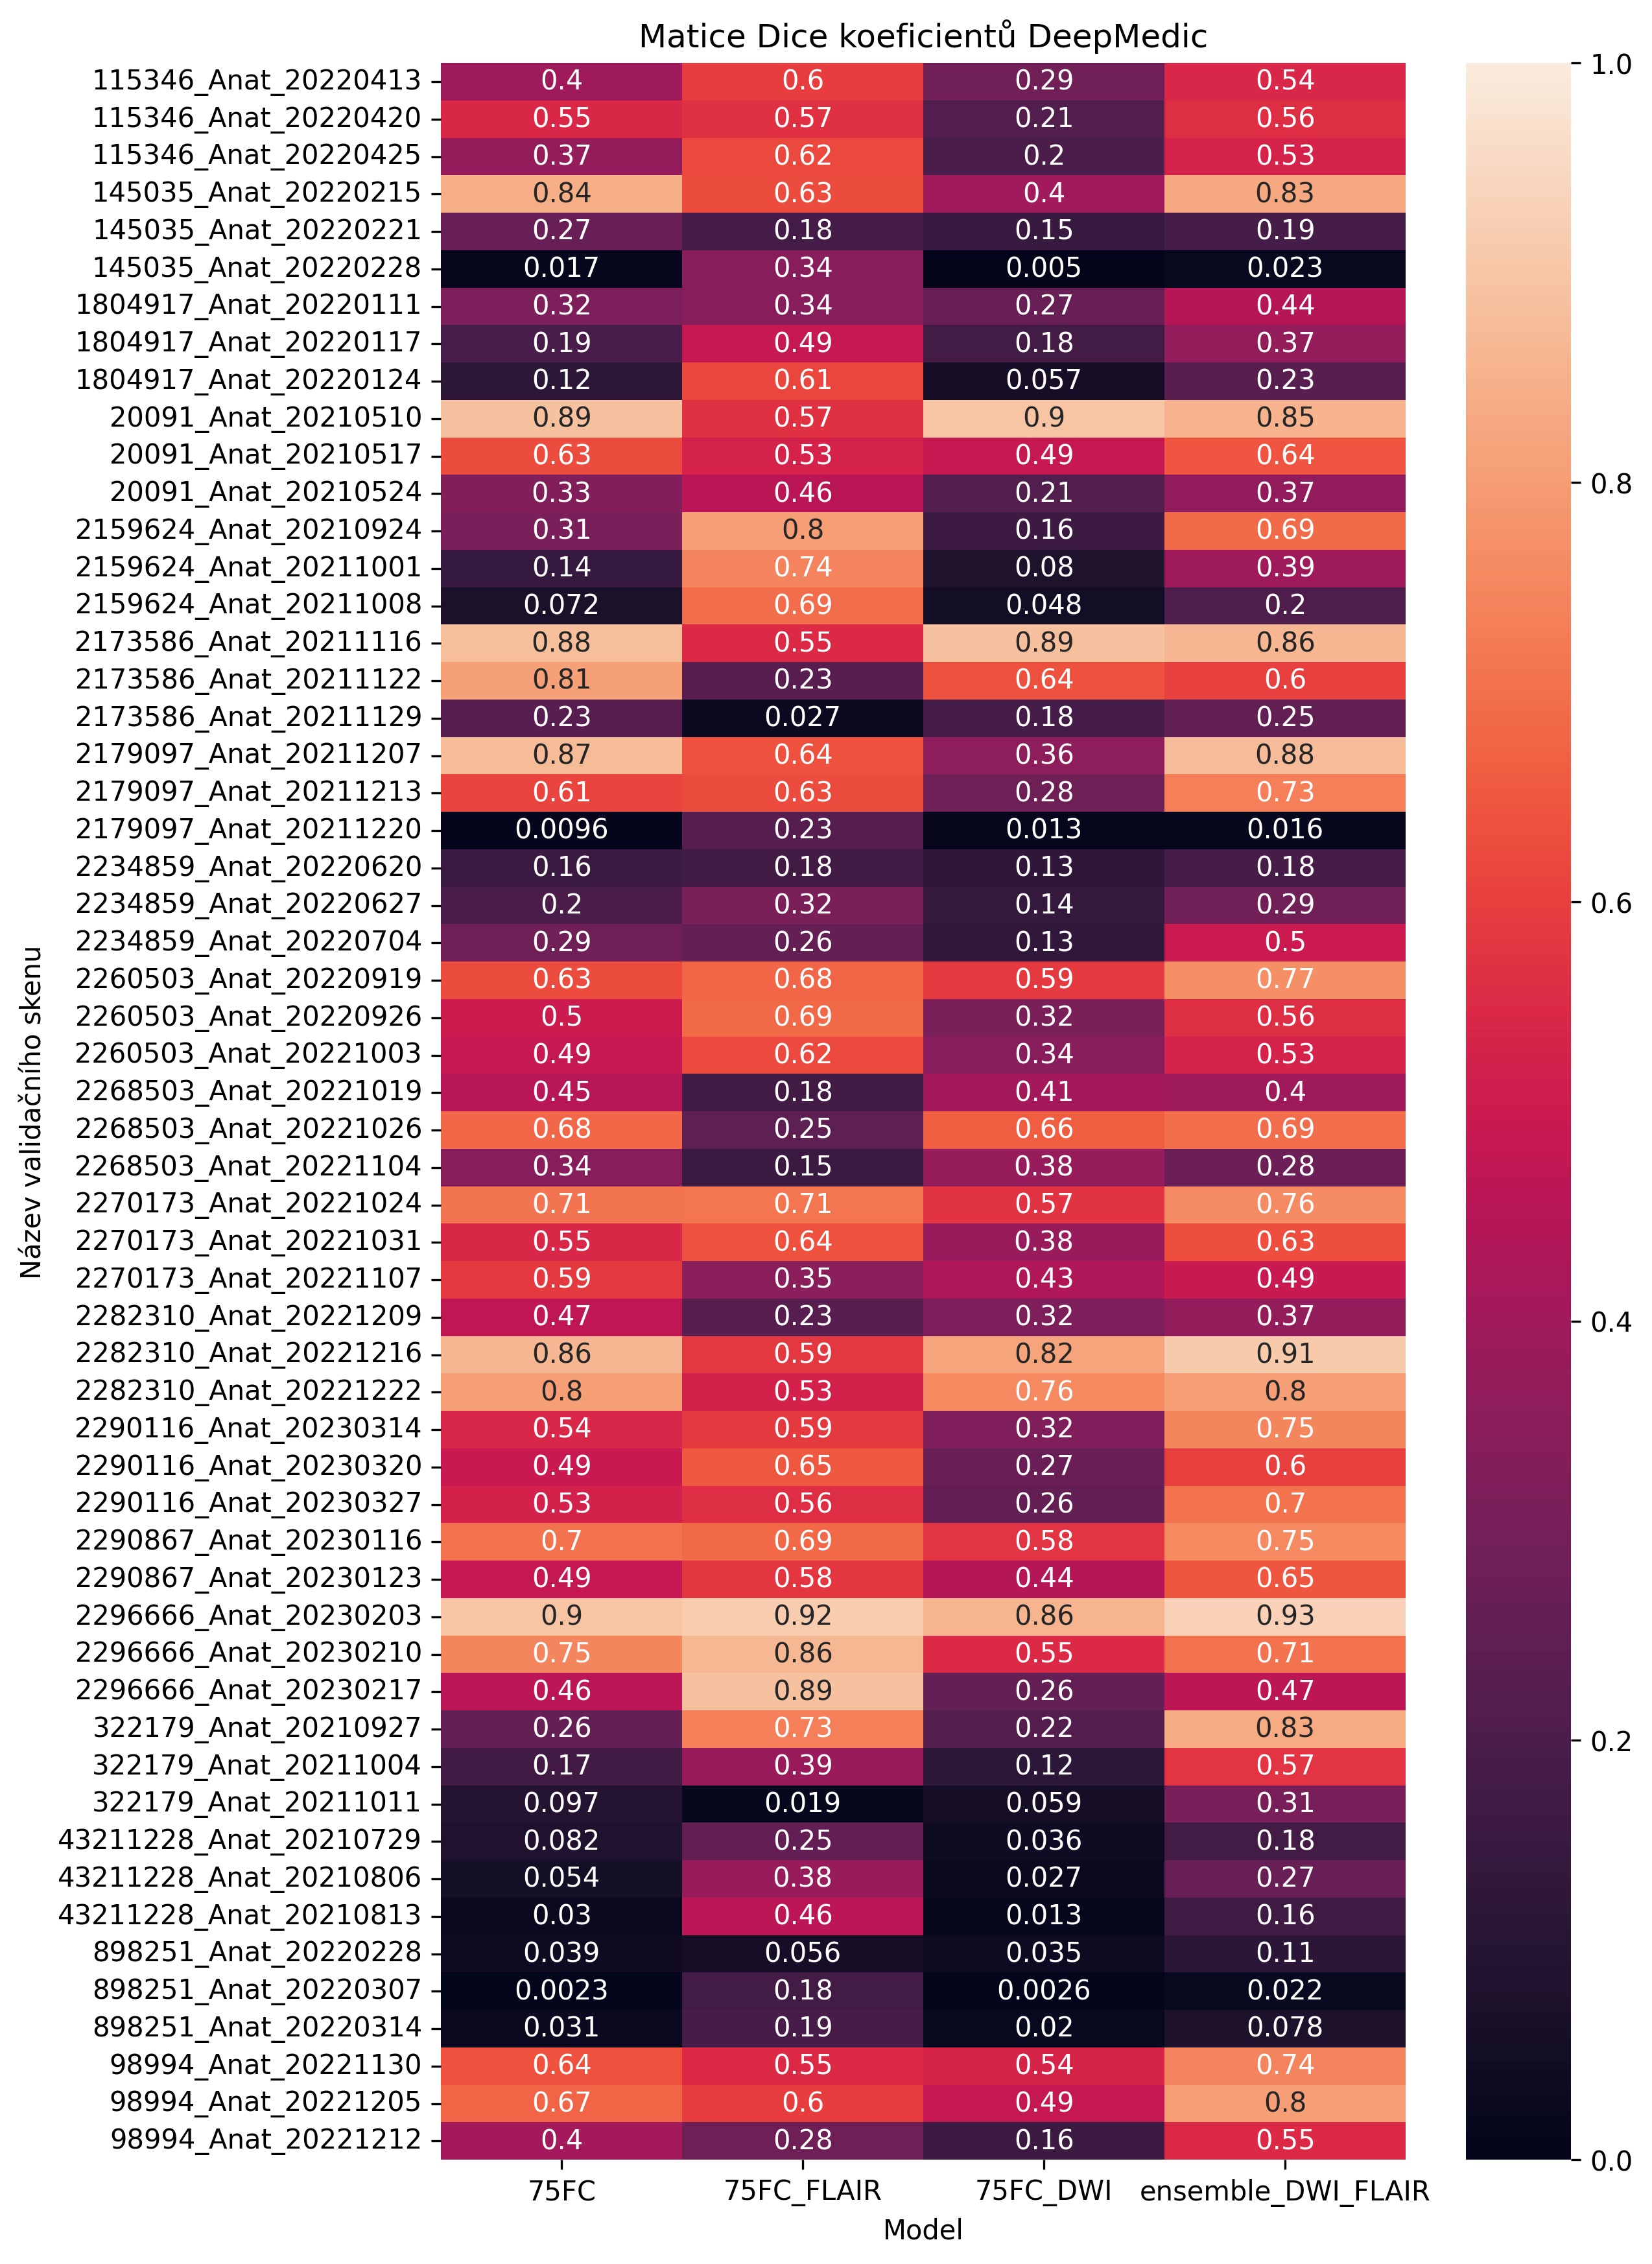

In [ ]:
models = ["75FC", "75FC_FLAIR", "75FC_DWI", "ensemble_DWI_FLAIR"]
matrix = (
    deepmedic[deepmedic["model"].isin(models)]
    .pivot(index="name", columns="model", values="dc")
    .reindex(columns=models)
)

plt.figure(figsize=(8, 14))
ax = sns.heatmap(data=matrix, xticklabels=models, vmin=0, vmax=1, annot=True)
ax.set_title("Matice Dice koeficientů DeepMedic")
ax.set_xlabel("Model")
ax.set_ylabel("Název validačního skenu")

Text(212.16666666666663, 0.5, 'Název validačního skenu')

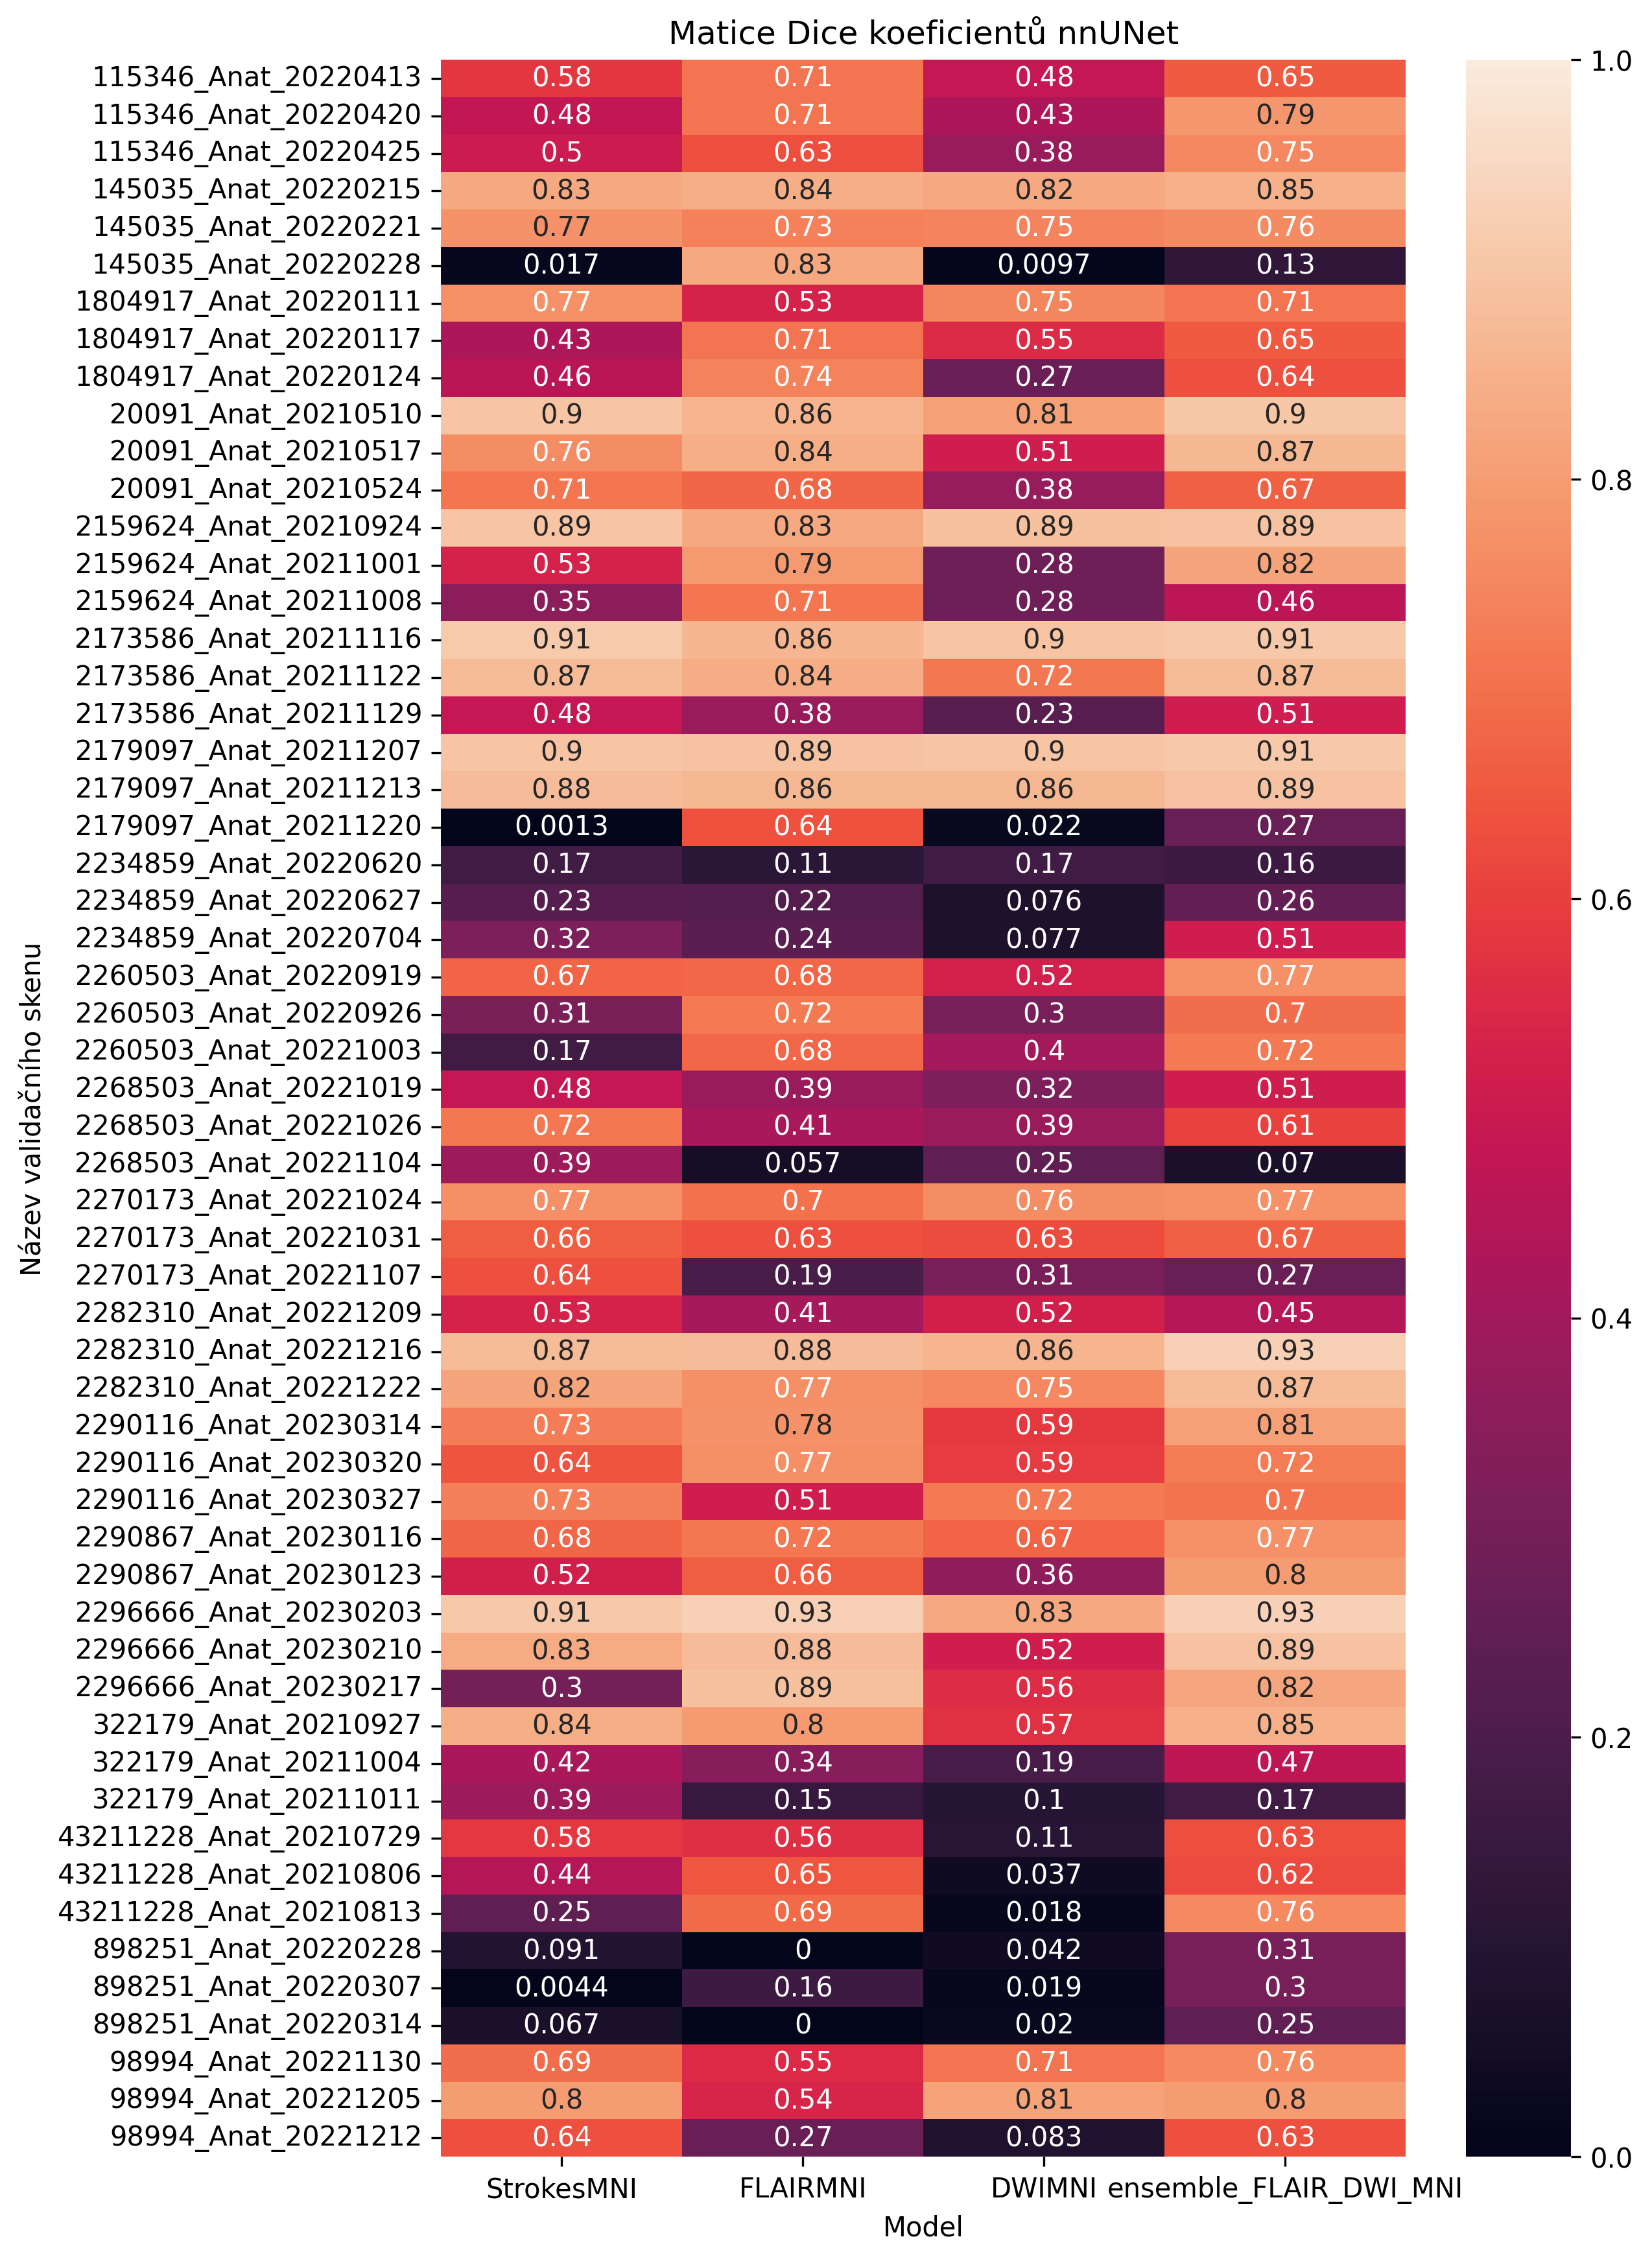

In [ ]:
models = ["StrokesMNI", "FLAIRMNI", "DWIMNI", "ensemble_FLAIR_DWI_MNI"]
matrix = (
    nnunet[nnunet["model"].isin(models)]
    .pivot(index="name", columns="model", values="dc")
    .reindex(columns=models)
)

plt.figure(figsize=(8, 14))
ax = sns.heatmap(data=matrix, xticklabels=models, vmin=0, vmax=1, annot=True)
ax.set_title("Matice Dice koeficientů nnUNet")
ax.set_xlabel("Model")
ax.set_ylabel("Název validačního skenu")